In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer
from classes.lrfs import lrfs as LRFS
from classes.igmf import igmf as IGMF
from classes.pmu import pmu as PMU
from classes.d2f import d2f as D2F
from classes.scls import scls as SCLS
from classes.mdmr import mdmr as MDMR
from classes.lsmfs  import  lsmfs as LSMFS
from classes.mlsmfs import mlsmfs as MLSMFS
from classes.ppt_mi import ppt_mi as PPT_MI
import argparse
from tqdm import tqdm
import os
import time
from evaluation import classify
from data import read_data

In [2]:
foldNum = 10
defaultmethods = {'LRFS', 'PPT_MI', 'IGMF', 'PMU', 'D2F', 'SCLS','MDMR', 'LSMFS', 'MLSMFS'}
parser = argparse.ArgumentParser()
parser.add_argument('--data-path', type=str, required=False,default="./datasets/")
parser.add_argument('--datasets', type=str, nargs='+', required=False,default=['newdatas'])
parser.add_argument('--fs-methods', type=str, nargs='+', required=False,default= defaultmethods)
parser.add_argument('--output-path', type=str, required=False, default='./results')
parser.add_argument('--selection-type', type=str, required=False, default='rank')
parser.add_argument('--num-of-features', type=int, required=False, default=50)
parser.add_argument('--eval-mode', type=str, default='pre_eval')
parser.add_argument('--classifiers', type=str, nargs='+', required=False, default=['BinaryRelevanceRf'])
parser.add_argument('--metrics', type=str, nargs='+', required=False, default=['hamming','ranking','f1_score','microfscore','coverage','averageprecisionscore','accuracyscore','zeroone'])
args = parser.parse_args(args=[])
if args.selection_type not in ['rank', 'fixed_num']: 
    raise ValueError('The selecion_method should be in [rank, fixed_num]')
method_dispatcher = {'LRFS':LRFS, 'PPT_MI':PPT_MI,'IGMF':IGMF, 'PMU':PMU, 'D2F':D2F, 'SCLS':SCLS,'MDMR':MDMR, 'LSMFS':LSMFS, 'MLSMFS':MLSMFS }

In [3]:
# 更新权重的函数，调整以适应新的 performance_history 结构
def update_weights(performance_history, beta=0.9):
    weighted_performance = {method: {metric: 0 for metric in args.metrics} for method in performance_history}
    for method, metrics_scores in performance_history.items():
        for metric, scores in metrics_scores.items():
            weighted_sum = sum(beta ** i * score for i, score in enumerate(scores[::-1]))
            total_weight = sum(beta ** i for i in range(len(scores)))
            weighted_performance[method][metric] = weighted_sum / total_weight if total_weight != 0 else 0
    
    # 计算每个方法的加权平均分数
    weights = {}
    for method in weighted_performance:
        method_scores = weighted_performance[method].values()
        weights[method] = sum(method_scores) / len(method_scores) if method_scores else 0
    
    # 归一化权重
    total_performance = sum(weights.values())
    weights = {method: (score / total_performance if total_performance != 0 else 0) for method, score in weights.items()}
    return weights


# 动态权重调整并获取特征重要性
def getFeatureImportance(X_train, y_train, fs_methods, method_weights):
    feature_importance = np.zeros(X_train.shape[1])
    for method, weight in zip(fs_methods, method_weights):
        fs = method_dispatcher[method]()
        rank = fs.rank(X_train, y_train)
        rank = np.array(rank, dtype=np.float64)
        weight = float(weight)        
        feature_importance += weight * rank  # 使用实际的特征重要性分数
    return feature_importance


def StackingRankImproved(allRank, totalNum, fs_methods, method_weights):
    feature_subsets = []
    # 获取每个方法的特征重要性并保存其前 totalNum 个最重要的特征
    feature_importance = getFeatureImportance(X_train, y_train, fs_methods, method_weights)

    # 根据特征重要性排序
    important_features = np.argsort(feature_importance)[::-1]

    # 获取前 totalNum 个最重要的特征
    for i in range(totalNum):
        top_features = important_features[:i+1].tolist()
        feature_subsets.append(top_features)

    return feature_subsets

In [4]:
FoldallStackingRank=[] #存放所有fold下面的stackRank 
time_empty_matrix = np.zeros((foldNum, len(defaultmethods)+1)) #存放每次计算所有方法的耗时
defaultmethods = ['LRFS', 'PPT_MI', 'IGMF', 'PMU', 'D2F', 'SCLS','MDMR', 'LSMFS', 'MLSMFS','stackingmethod']
metrics = ['hamming','ranking','f1_score','microfscore','coverage','averageprecisionscore','accuracyscore','zeroone']

In [5]:
performance_history = {method: {metric: [1.0] for metric in args.metrics} for method in defaultmethods}
method_weights = update_weights(performance_history)

for fold in range(0,foldNum):
    #splitdata
    readData = pd.read_csv("./datasets/newdatas/data.csv")
    Y = readData.iloc[:,0:4].values
    X = readData.iloc[:,4:readData.shape[1]].values
    X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.3, random_state=fold)
    np.savetxt("./datasets/newdatas/train.csv",X_train,delimiter=",")
    np.savetxt("./datasets/newdatas/test.csv",X_test,delimiter=",")
    np.savetxt("./datasets/newdatas/train_labels.csv",y_train,delimiter=",")
    np.savetxt("./datasets/newdatas/test_labels.csv",y_test,delimiter=",")
    allRank={} 
    new_performance = {method: {metric: [] for metric in args.metrics} for method in defaultmethods}
    
    for d in args.datasets: 
        X_train, y_train, X_test, y_test = read_data(d_name= d, d_path= args.data_path)
        est = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')
        est.fit(X_train)
        X_train = est.transform(X_train).astype(int)
        X_test = est.transform(X_test).astype(int)
        y_train = y_train.astype(int)
        rank_empty_matrix = np.zeros((X_train.shape[1],len(defaultmethods))) #存放每次计算所有方法的选择到的特征 55*10
        methodcount = 0
        methodlist = []
        
        for c in args.classifiers:  # 这里添加一个循环来遍历分类器
            for method in args.fs_methods: 
                results = classify(X_train, y_train, X_test, y_test, c, args.metrics)
                # 指标转换
                for metric in results:
                    if metric in ['hamming', 'ranking', 'coverage', 'zeroone']:
                        # 对于 '越小越好' 的指标，进行转换
                        results[metric] = 1 - results[metric]
                for metric in args.metrics: 
                    new_performance[method][metric].append(results[metric])

                methodlist.append(method)
                start = time.time()
                message = 30*'='+'  dataset:{}  method:{}'.format(d,method)+30*'='
                print(message)          
                fs = method_dispatcher[method]()
                if args.selection_type == 'rank':            
                    rank = fs.rank(X_train, y_train, mode=args.eval_mode)
                elif args.selection_type == 'fixed_num':
                    rank = fs.select(X_train, y_train,args.num_of_features, mode=args.eval_mode)
                dir_name = args.output_path + r'\SelectedSubsets' 
                if not (os.path.isdir(dir_name)):
                    os.mkdir(dir_name) 
                dir_name += r'\{}'.format(d)
                if not (os.path.isdir(dir_name)):
                    os.mkdir(dir_name)
                dir_name += r'\{}'.format(fold)
                if not (os.path.isdir(dir_name)):
                    os.mkdir(dir_name)    
                filename = dir_name + r'\\' + method + '.csv'
                np.savetxt(filename, rank, delimiter=',', fmt = '%d')    
                # keep the selected subsets 
                allRank[method] = rank
                rank_empty_matrix[:,methodcount] = rank
                if args.classifiers != None:
                    for c in args.classifiers:
                        dir_name = args.output_path + '\\' + "Accuracies" 
                        if not (os.path.isdir(dir_name)):
                            os.mkdir(dir_name)
                        dir_name += r'\{}'.format(d) 
                        if not (os.path.isdir(dir_name)):
                            os.mkdir(dir_name) 
                        dir_name += r'\{}'.format(c)
                        if not (os.path.isdir(dir_name)):
                            os.mkdir(dir_name) 
                        with tqdm(total=len(rank), ncols=80) as t:
                            t.set_description('{} Classification in Progress '.format(c))
                            for k in range(1, len(rank)+1):
                                res = classify(X_train[:,rank[:k]], y_train, X_test[:,rank[:k]], y_test, c, args.metrics)
                                for m in args.metrics: 
                                    dir_name_m = dir_name +r'\{}'.format(m)
                                    if not (os.path.isdir(dir_name_m)):
                                        os.mkdir(dir_name_m) 
                                    dir_name_m += r'\{}'.format(fold)
                                    if not (os.path.isdir(dir_name_m)):
                                        os.mkdir(dir_name_m) 	
                                    filename = dir_name_m +  "\\" +  method +  '.csv'
                                    if k == 1:
                                        np.savetxt(filename, [res[m]])
                                    else: 
                                        with open(filename, "ab") as f:
                                            np.savetxt(f, [res[m]])
                                t.update(1)         
                end = time.time()
                time_empty_matrix[fold,methodcount] = end-start
                methodcount=methodcount+1
            start = time.time()
        
        # 在每个 fold 后更新 performance_history
        for method, metrics_scores in new_performance.items():
            for metric, scores in metrics_scores.items():
                avg_score = np.mean(scores)
                performance_history[method][metric].append(avg_score)    
        
        # 更新权重
        method_weights = update_weights(performance_history)
        method_weights = [float(w) for w in method_weights.values()]  # 确保权重是数值类型
        
        allStackingRank = StackingRankImproved(allRank, totalNum=55, fs_methods=args.fs_methods, method_weights=method_weights)
        # 确保 allStackingRank 是一个列表的列表
        if not all(isinstance(sublist, list) for sublist in allStackingRank):
            raise ValueError("allStackingRank 应该是一个列表的列表。请检查 StackingRankImproved 函数的返回值。")
    
        FoldallStackingRank.append(allStackingRank)
        
        method = "stackingmethod"
        methodlist.append(method)
        dir_name = args.output_path + r'\SelectedSubsets' 
        if not (os.path.isdir(dir_name)):
            os.mkdir(dir_name) 
        dir_name += r'\{}'.format(d)
        if not (os.path.isdir(dir_name)):
            os.mkdir(dir_name)
        dir_name += r'\{}'.format(fold)
        if not (os.path.isdir(dir_name)):
            os.mkdir(dir_name)    
        filename = dir_name + r'\\' + method + '.csv'
        
        
        max_length = max(len(sublist) for sublist in allStackingRank)
        padded_list = [sublist + [None]*(max_length - len(sublist)) for sublist in allStackingRank]
        padded_array = np.array(padded_list)
        np.savetxt(filename, padded_array, delimiter=',', fmt='%s')
        
        message = 30*'='+'  dataset:{}  method:{}'.format(d,method)+30*'='
        print(message)
        if args.classifiers != None:
            for c in args.classifiers:
                dir_name = args.output_path + '\\' + "Accuracies" 
                if not (os.path.isdir(dir_name)):
                    os.mkdir(dir_name)
                dir_name += r'\{}'.format(d) 
                if not (os.path.isdir(dir_name)):
                    os.mkdir(dir_name) 
                dir_name += r'\{}'.format(c)
                if not (os.path.isdir(dir_name)):
                    os.mkdir(dir_name) 
                with tqdm(total=len(allStackingRank), ncols=80) as t:
                    t.set_description('{} Classification in Progress '.format(c)) 
                    for k in range(0,len(allStackingRank)):
                        res = classify(X_train[:,allStackingRank[k]], y_train, X_test[:,allStackingRank[k]], y_test, c, args.metrics)
                        for m in args.metrics: 
                            dir_name_m = dir_name +r'\{}'.format(m)
                            if not (os.path.isdir(dir_name_m)):
                                os.mkdir(dir_name_m) 
                            dir_name_m += r'\{}'.format(fold)
                            if not (os.path.isdir(dir_name_m)):
                                os.mkdir(dir_name_m)  
                            filename = dir_name_m +  "\\" +  method +  '.csv'
                            if k == 0:
                                np.savetxt(filename, [res[m]])
                            else: 
                                with open(filename, "ab") as f:
                                    np.savetxt(f, [res[m]])
                        t.update(1)                                 
        end = time.time()
        time_empty_matrix[fold,methodcount] = end-start
        

C:\ProgramData\anaconda3\envs\PyIT_MLFS\lib\site-packages\sklearn\preprocessing\_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


使用的分类器： BinaryRelevanceRf
==============================  dataset:newdatas  method:LSMFS==============================


BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:22,  2.38i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:22,  2.34i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:22,  2.27i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:22,  2.26i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:22,  2.23i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:02<00:22,  2.16i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:03<00:23,  2.03i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:03<00:24,  1.91i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:04<00:25,  1.77i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:05<00:26,  1.67

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:05<00:28,  1.57

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:06<00:29,  1.47

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:07<00:30,  1.38

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:08<00:31,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:09<00:33,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:10<00:34,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:11<00:36,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:12<00:36,  1.00

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:13<00:36,  1.03

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:14<00:36,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:15<00:36,  1.06

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:16<00:35,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:18<00:34,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:19<00:33,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:20<00:33,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:21<00:32,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:22<00:31,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:23<00:30,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:25<00:30,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:26<00:29,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:27<00:28,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:28<00:27,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:29<00:25,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:30<00:24,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:32<00:23,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:33<00:22,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:34<00:21,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:35<00:20,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:37<00:19,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:38<00:18,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:39<00:17,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:40<00:15,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:41<00:14,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:43<00:13,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:44<00:12,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:45<00:11,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:47<00:10,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:48<00:08,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:49<00:07,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:51<00:06,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:52<00:05,  1.33

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:53<00:04,  1.34

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [00:55<00:02,  1.34

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [00:56<00:01,  1.34

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [00:57<00:00,  1.05


使用的分类器： BinaryRelevanceRf
==============================  dataset:newdatas  method:MLSMFS==============================


BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:22,  2.43i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:21,  2.41i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:22,  2.35i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:22,  2.28i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:22,  2.21i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:02<00:23,  2.06i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:03<00:24,  1.94i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:03<00:26,  1.79i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:04<00:27,  1.67i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:05<00:29,  1.55

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:06<00:30,  1.44

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:07<00:32,  1.34

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:07<00:33,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:08<00:33,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:09<00:34,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:10<00:35,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:11<00:36,  1.04

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:12<00:36,  1.02

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:14<00:36,  1.01

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:15<00:35,  1.03

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:16<00:35,  1.04

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:17<00:35,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:18<00:34,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:19<00:33,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:20<00:33,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:21<00:32,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:23<00:31,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:24<00:30,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:25<00:29,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:26<00:28,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:27<00:27,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:28<00:26,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:30<00:25,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:31<00:24,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:32<00:23,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:33<00:22,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:34<00:21,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:35<00:20,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:37<00:19,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:38<00:18,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:39<00:17,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:40<00:15,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:42<00:14,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:43<00:13,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:44<00:12,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:45<00:11,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:47<00:09,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:48<00:08,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:49<00:07,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:50<00:06,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:52<00:05,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:53<00:03,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [00:54<00:02,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [00:56<00:01,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [00:57<00:00,  1.05


使用的分类器： BinaryRelevanceRf
==============================  dataset:newdatas  method:LRFS==============================


BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:21,  2.56i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:21,  2.51i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:21,  2.43i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:21,  2.32i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:22,  2.20i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:02<00:23,  2.06i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:03<00:25,  1.88i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:04<00:27,  1.69i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:04<00:30,  1.51i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:05<00:32,  1.38

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:06<00:34,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:07<00:35,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:08<00:36,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:09<00:36,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:10<00:36,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:11<00:37,  1.04

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:12<00:37,  1.01

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:13<00:37,  1.01

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:14<00:37,  1.04

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:15<00:36,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:16<00:35,  1.06

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:18<00:35,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:19<00:34,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:20<00:33,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:21<00:33,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:22<00:32,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:23<00:32,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:24<00:30,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:26<00:30,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:27<00:29,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:28<00:28,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:29<00:26,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:30<00:25,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:31<00:24,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:33<00:23,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:34<00:22,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:35<00:21,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:36<00:20,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:38<00:19,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:39<00:18,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:40<00:17,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:41<00:16,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:43<00:14,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:44<00:13,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:45<00:12,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:46<00:11,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:48<00:10,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:49<00:08,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:50<00:07,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:52<00:06,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:53<00:05,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:54<00:03,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [00:55<00:02,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [00:57<00:01,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [00:58<00:00,  1.07


使用的分类器： BinaryRelevanceRf
==============================  dataset:newdatas  method:D2F==============================


Calculating Relevamce Matrix: 100%|████████████| 55/55 [00:00<00:00, 149.17it/s]
Calculating Multivariate Redundancy Matrix: 100%|█| 55/55 [00:50<00:00,  1.08it/
BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:21,  2.52i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:21,  2.50i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:21,  2.47i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:21,  2.35i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:22,  2.25i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:02<00:23,  2.10i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:03<00:25,  1.91i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:04<00:27,  1.71i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:04<00:30,  1.51i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:05<00:33,  1.35

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:06<00:35,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:07<00:36,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:08<00:37,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:09<00:37,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:10<00:38,  1.04

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:11<00:39,  1.00

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:12<00:39,  1.03

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:14<00:39,  1.06

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:15<00:38,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:16<00:37,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:17<00:36,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:18<00:35,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:19<00:35,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:20<00:34,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:21<00:33,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:23<00:33,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:24<00:32,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:25<00:31,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:26<00:30,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:27<00:29,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:28<00:28,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:30<00:27,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:31<00:26,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:32<00:25,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:33<00:23,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:35<00:23,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:36<00:22,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:37<00:21,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:38<00:20,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:40<00:18,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:41<00:17,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:42<00:16,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:44<00:15,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:45<00:14,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:46<00:12,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:47<00:11,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:49<00:10,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:50<00:08,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:51<00:07,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:53<00:06,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:54<00:05,  1.35

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:55<00:04,  1.36

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [00:57<00:02,  1.36

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [00:58<00:01,  1.36

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [01:00<00:00,  1.09


使用的分类器： BinaryRelevanceRf
==============================  dataset:newdatas  method:PPT_MI==============================


BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:22,  2.45i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:22,  2.37i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:22,  2.34i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:23,  2.22i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:24,  2.03i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:02<00:26,  1.84i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:03<00:28,  1.67i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:04<00:30,  1.56i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:05<00:32,  1.43i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:06<00:34,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:07<00:35,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:07<00:36,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:08<00:37,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:09<00:37,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:10<00:37,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:11<00:37,  1.03

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:13<00:38,  1.00

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:14<00:37,  1.02

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:15<00:37,  1.04

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:16<00:36,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:17<00:36,  1.06

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:18<00:35,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:19<00:34,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:20<00:33,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:21<00:33,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:22<00:32,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:24<00:31,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:25<00:30,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:26<00:29,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:27<00:28,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:28<00:27,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:29<00:26,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:31<00:25,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:32<00:24,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:33<00:23,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:34<00:22,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:35<00:21,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:37<00:20,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:38<00:19,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:39<00:18,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:41<00:17,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:42<00:16,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:43<00:15,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:44<00:13,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:46<00:12,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:47<00:11,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:48<00:10,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:49<00:08,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:51<00:07,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:52<00:06,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:53<00:05,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:55<00:03,  1.33

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [00:56<00:02,  1.33

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [00:58<00:01,  1.34

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [00:59<00:00,  1.08


使用的分类器： BinaryRelevanceRf
==============================  dataset:newdatas  method:IGMF==============================


BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:21,  2.48i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:21,  2.45i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:22,  2.35i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:23,  2.17i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:24,  2.00i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:02<00:26,  1.82i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:03<00:29,  1.62i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:04<00:30,  1.52i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:05<00:33,  1.39i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:06<00:34,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:07<00:36,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:08<00:37,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:09<00:38,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:10<00:38,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:11<00:38,  1.03

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:12<00:38,  1.00

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:13<00:38,  1.02

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:14<00:38,  1.03

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:15<00:37,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:16<00:37,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:17<00:36,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:18<00:35,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:19<00:34,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:20<00:33,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:22<00:33,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:23<00:32,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:24<00:31,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:25<00:30,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:26<00:30,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:27<00:28,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:29<00:27,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:30<00:26,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:31<00:25,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:32<00:24,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:33<00:23,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:34<00:22,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:36<00:21,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:37<00:20,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:38<00:19,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:39<00:18,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:41<00:17,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:42<00:16,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:43<00:14,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:44<00:13,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:46<00:12,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:47<00:11,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:48<00:10,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:49<00:08,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:51<00:07,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:52<00:06,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:53<00:05,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:55<00:03,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [00:56<00:02,  1.34

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [00:58<00:01,  1.35

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [00:59<00:00,  1.08


使用的分类器： BinaryRelevanceRf
==============================  dataset:newdatas  method:PMU==============================


Calculating Relevamce Matrix: 100%|████████████| 55/55 [00:00<00:00, 143.37it/s]
Calculating Multi-Variate Relevance Matrix: 100%|█| 55/55 [00:03<00:00, 15.26it/
BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:21,  2.48i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:22,  2.40i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:22,  2.28i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:24,  2.09i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:26,  1.88i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:03<00:29,  1.66i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:04<00:32,  1.48i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:04<00:34,  1.35i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:05<00:38,  1.20i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:06<00:40,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:08<00:41,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:09<00:42,  1.01

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:10<00:43,  1.03

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:11<00:43,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:12<00:42,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:13<00:42,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:14<00:42,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:15<00:42,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:17<00:41,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:18<00:40,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:19<00:39,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:20<00:38,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:21<00:37,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:23<00:36,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:24<00:36,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:25<00:35,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:26<00:34,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:28<00:33,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:29<00:32,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:30<00:31,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:31<00:30,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:33<00:28,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:34<00:27,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:35<00:26,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:36<00:25,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:38<00:24,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:39<00:23,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:40<00:22,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:42<00:20,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:43<00:19,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:44<00:18,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:46<00:17,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:47<00:15,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:48<00:14,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:50<00:13,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:51<00:11,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:52<00:10,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:54<00:09,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:55<00:07,  1.33

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:56<00:06,  1.34

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:58<00:05,  1.34

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:59<00:04,  1.34

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [01:00<00:02,  1.34

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [01:02<00:01,  1.33

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [01:03<00:00,  1.15


使用的分类器： BinaryRelevanceRf
==============================  dataset:newdatas  method:MDMR==============================


Calculating Relevamce Matrix: 100%|████████████| 55/55 [00:00<00:00, 138.68it/s]
Calculating Multivariate Redundancy Matrix: 100%|█| 55/55 [00:51<00:00,  1.07it/
BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:21,  2.52i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:21,  2.47i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:21,  2.45i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:21,  2.34i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:22,  2.23i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:02<00:23,  2.09i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:03<00:25,  1.89i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:04<00:27,  1.68i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:04<00:31,  1.48i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:05<00:33,  1.33

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:06<00:35,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:07<00:37,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:08<00:38,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:09<00:38,  1.06

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:10<00:38,  1.04

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:11<00:38,  1.00

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:12<00:39,  1.03

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:14<00:38,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:15<00:38,  1.06

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:16<00:37,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:17<00:36,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:18<00:35,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:19<00:34,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:20<00:34,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:21<00:33,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:23<00:33,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:24<00:32,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:25<00:31,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:26<00:30,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:27<00:29,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:29<00:28,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:30<00:27,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:31<00:26,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:32<00:25,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:33<00:24,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:35<00:23,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:36<00:22,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:37<00:21,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:39<00:20,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:40<00:18,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:41<00:17,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:42<00:16,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:44<00:15,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:45<00:13,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:46<00:12,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:47<00:11,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:49<00:10,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:50<00:08,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:51<00:07,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:53<00:06,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:54<00:05,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:55<00:03,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [00:57<00:02,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [00:58<00:01,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [00:59<00:00,  1.09


使用的分类器： BinaryRelevanceRf
==============================  dataset:newdatas  method:SCLS==============================


BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:22,  2.44i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:22,  2.40i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:22,  2.33i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:22,  2.24i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:23,  2.11i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:02<00:24,  1.98i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:03<00:26,  1.80i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:04<00:28,  1.62i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:05<00:30,  1.49i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:05<00:32,  1.38

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:06<00:34,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:07<00:36,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:08<00:37,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:09<00:37,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:10<00:37,  1.06

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:11<00:38,  1.02

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:12<00:38,  1.01

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:13<00:37,  1.02

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:15<00:37,  1.04

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:16<00:36,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:17<00:36,  1.06

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:18<00:35,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:19<00:34,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:20<00:33,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:21<00:32,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:22<00:32,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:23<00:31,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:25<00:30,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:26<00:29,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:27<00:28,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:28<00:27,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:29<00:26,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:30<00:25,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:31<00:24,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:33<00:23,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:34<00:22,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:35<00:21,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:36<00:20,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:38<00:19,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:39<00:18,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:40<00:17,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:41<00:16,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:43<00:14,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:44<00:13,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:45<00:12,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:46<00:11,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:48<00:10,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:49<00:08,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:50<00:07,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:52<00:06,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:53<00:05,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:54<00:03,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [00:56<00:02,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [00:57<00:01,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [00:58<00:00,  1.07
C:\ProgramData\anaconda3\envs\PyIT_MLFS\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\ProgramData\anaconda3\envs\PyIT_MLFS\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Calculating Relevamce Matrix: 100%|████████████| 55/55 [00:00<00:00, 139.39it/s]
Calculating Multivariate Redundancy Matrix: 100%|█| 55/55 [00:51<00:00,  1.06it/
Calculating Relevamce Matrix: 100%|████████████| 55/55 [00:00<00:00, 143.67it/s]
Calculating Multi-Variate Relevance Matrix: 100%|█| 55/55 [00:03<00:00, 15.21it/
Calculating Relevamce Matrix: 100%|████████████| 55/55 [00:00<00:00, 141.54it/s]
Calculating Multivariate Redundancy Matrix: 100%|█| 55/55 [00:52<00:00,  1.04it/
Feature Selection in Progress : 100%|█████████| 55/55 [00:00<00:00, 2200.

==============================  dataset:newdatas  method:stackingmethod==============================


BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:22,  2.44i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:22,  2.39i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:22,  2.31i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:23,  2.16i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:24,  2.01i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:02<00:26,  1.84i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:03<00:28,  1.66i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:04<00:30,  1.53i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:05<00:33,  1.39i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:06<00:34,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:07<00:36,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:08<00:37,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:09<00:37,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:10<00:37,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:11<00:38,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:12<00:38,  1.01

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:13<00:38,  1.01

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:14<00:37,  1.03

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:15<00:37,  1.04

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:16<00:37,  1.06

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:17<00:36,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:18<00:35,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:19<00:34,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:20<00:33,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:21<00:32,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:23<00:32,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:24<00:31,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:25<00:30,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:26<00:29,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:27<00:28,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:28<00:27,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:30<00:26,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:31<00:25,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:32<00:24,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:33<00:23,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:34<00:22,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:36<00:21,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:37<00:20,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:38<00:19,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:39<00:18,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:41<00:17,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:42<00:16,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:43<00:14,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:44<00:13,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:45<00:12,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:47<00:11,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:48<00:10,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:49<00:08,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:51<00:07,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:52<00:06,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:53<00:05,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:55<00:03,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [00:56<00:02,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [00:57<00:01,  1.33

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [00:59<00:00,  1.07
C:\ProgramData\anaconda3\envs\PyIT_MLFS\lib\site-packages\sklearn\preprocessing\_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


使用的分类器： BinaryRelevanceRf
==============================  dataset:newdatas  method:LSMFS==============================


BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:22,  2.45i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:21,  2.44i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:22,  2.36i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:22,  2.29i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:22,  2.18i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:02<00:23,  2.05i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:03<00:25,  1.88i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:04<00:26,  1.78i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:04<00:27,  1.64i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:05<00:29,  1.51

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:06<00:31,  1.41

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:07<00:32,  1.33

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:08<00:33,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:09<00:34,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:10<00:35,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:11<00:36,  1.06

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:12<00:37,  1.03

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:13<00:37,  1.00

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:14<00:36,  1.02

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:15<00:36,  1.04

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:16<00:35,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:17<00:34,  1.06

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:18<00:34,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:19<00:33,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:20<00:32,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:21<00:32,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:23<00:31,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:24<00:30,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:25<00:29,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:26<00:28,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:27<00:27,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:28<00:26,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:30<00:25,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:31<00:24,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:32<00:23,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:33<00:22,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:34<00:21,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:36<00:20,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:37<00:19,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:38<00:18,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:39<00:17,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:41<00:16,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:42<00:15,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:43<00:13,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:44<00:12,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:46<00:11,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:47<00:10,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:48<00:08,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:50<00:07,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:51<00:06,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:52<00:05,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:54<00:03,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [00:55<00:02,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [00:56<00:01,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [00:57<00:00,  1.05


使用的分类器： BinaryRelevanceRf
==============================  dataset:newdatas  method:MLSMFS==============================


BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:21,  2.52i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:21,  2.46i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:21,  2.43i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:22,  2.31i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:22,  2.22i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:02<00:23,  2.08i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:03<00:24,  1.95i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:03<00:25,  1.81i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:04<00:27,  1.65i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:05<00:29,  1.55

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:06<00:30,  1.44

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:07<00:32,  1.34

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:07<00:33,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:08<00:34,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:09<00:35,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:10<00:36,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:11<00:37,  1.03

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:13<00:36,  1.00

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:14<00:37,  1.03

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:15<00:36,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:16<00:35,  1.06

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:17<00:35,  1.06

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:18<00:34,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:19<00:33,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:20<00:33,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:21<00:32,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:23<00:31,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:24<00:30,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:25<00:29,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:26<00:28,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:27<00:27,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:28<00:26,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:29<00:25,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:31<00:24,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:32<00:23,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:33<00:22,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:34<00:21,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:35<00:20,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:37<00:19,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:38<00:18,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:39<00:17,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:40<00:15,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:42<00:14,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:43<00:13,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:44<00:12,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:45<00:11,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:47<00:09,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:48<00:08,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:49<00:07,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:51<00:06,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:52<00:05,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:53<00:03,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [00:55<00:02,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [00:56<00:01,  1.33

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [00:57<00:00,  1.05


使用的分类器： BinaryRelevanceRf
==============================  dataset:newdatas  method:LRFS==============================


BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:21,  2.51i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:21,  2.48i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:22,  2.36i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:22,  2.30i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:23,  2.16i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:02<00:24,  2.03i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:03<00:25,  1.89i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:04<00:27,  1.74i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:04<00:29,  1.57i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:05<00:31,  1.44

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:06<00:33,  1.33

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:07<00:34,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:08<00:36,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:09<00:37,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:10<00:37,  1.06

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:11<00:38,  1.01

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:12<00:38,  1.01

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:13<00:38,  1.03

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:14<00:37,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:15<00:37,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:17<00:36,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:18<00:35,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:19<00:35,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:20<00:34,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:21<00:34,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:22<00:33,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:23<00:32,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:25<00:31,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:26<00:30,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:27<00:29,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:28<00:27,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:29<00:26,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:30<00:25,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:32<00:24,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:33<00:23,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:34<00:22,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:35<00:21,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:37<00:20,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:38<00:19,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:39<00:18,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:40<00:17,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:42<00:16,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:43<00:14,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:44<00:13,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:45<00:12,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:47<00:11,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:48<00:10,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:49<00:08,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:50<00:07,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:52<00:06,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:53<00:05,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:54<00:03,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [00:56<00:02,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [00:57<00:01,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [00:58<00:00,  1.07


使用的分类器： BinaryRelevanceRf
==============================  dataset:newdatas  method:D2F==============================


Calculating Relevamce Matrix: 100%|████████████| 55/55 [00:00<00:00, 142.34it/s]
Calculating Multivariate Redundancy Matrix: 100%|█| 55/55 [00:51<00:00,  1.08it/
BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:21,  2.51i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:21,  2.50i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:21,  2.40i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:114: RuntimeWarning: invalid value encountered in scalar divide
  score = ((1+beta_val)*(prec*rec))/(beta_val*(prec+rec))
BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:22,  2.26i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:24,  2.08i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:02<00:26,  1.88i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:03<00:28,  1.69i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:04<00:31,  1.51i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:05<00:33,  1.36i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:06<00:36,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:07<00:38,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:08<00:39,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:09<00:40,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:10<00:40,  1.01

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:11<00:40,  1.01

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:12<00:40,  1.04

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:13<00:40,  1.06

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:14<00:39,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:15<00:39,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:17<00:38,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:18<00:37,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:19<00:37,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:20<00:36,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:21<00:35,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:22<00:34,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:24<00:33,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:25<00:32,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:26<00:32,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:27<00:31,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:28<00:30,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:30<00:28,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:31<00:27,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:32<00:26,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:33<00:25,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:34<00:24,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:36<00:23,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:37<00:22,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:38<00:21,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:40<00:20,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:41<00:19,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:42<00:17,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:44<00:16,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:45<00:15,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:46<00:14,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:47<00:12,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:49<00:11,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:50<00:10,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:51<00:08,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:53<00:07,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:54<00:06,  1.33

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:55<00:05,  1.35

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:57<00:04,  1.35

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [00:58<00:02,  1.34

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [00:59<00:01,  1.34

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [01:01<00:00,  1.11


使用的分类器： BinaryRelevanceRf
==============================  dataset:newdatas  method:PPT_MI==============================


BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:21,  2.51i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:21,  2.47i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:21,  2.38i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:22,  2.24i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:23,  2.09i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:02<00:25,  1.91i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:03<00:27,  1.74i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:04<00:29,  1.60i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:05<00:31,  1.46i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:05<00:33,  1.35

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:06<00:34,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:07<00:36,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:08<00:37,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:09<00:38,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:10<00:38,  1.04

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:12<00:39,  1.01

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:13<00:39,  1.04

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:14<00:39,  1.06

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:15<00:38,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:16<00:37,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:17<00:37,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:18<00:36,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:19<00:35,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:20<00:34,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:22<00:33,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:23<00:33,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:24<00:32,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:25<00:31,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:26<00:30,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:27<00:28,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:29<00:27,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:30<00:26,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:31<00:25,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:32<00:24,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:33<00:23,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:35<00:22,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:36<00:21,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:37<00:20,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:38<00:19,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:39<00:18,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:41<00:17,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:42<00:15,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:43<00:14,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:44<00:13,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:46<00:12,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:47<00:11,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:48<00:10,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:50<00:08,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:51<00:07,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:52<00:06,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:54<00:05,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:55<00:03,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [00:56<00:02,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [00:57<00:01,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [00:59<00:00,  1.08


使用的分类器： BinaryRelevanceRf
==============================  dataset:newdatas  method:IGMF==============================


BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:22,  2.36i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:22,  2.34i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:22,  2.28i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:24,  2.11i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:25,  1.94i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:03<00:28,  1.74i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:03<00:30,  1.58i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:04<00:32,  1.47i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:05<00:33,  1.36i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:06<00:35,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:07<00:37,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:08<00:37,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:09<00:37,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:10<00:38,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:11<00:38,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:12<00:38,  1.01

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:13<00:38,  1.01

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:14<00:38,  1.04

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:15<00:38,  1.06

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:16<00:37,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:17<00:37,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:18<00:36,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:20<00:34,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:21<00:33,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:22<00:32,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:23<00:32,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:24<00:31,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:25<00:30,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:26<00:29,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:27<00:28,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:29<00:27,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:30<00:26,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:31<00:25,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:32<00:24,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:33<00:23,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:34<00:22,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:36<00:21,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:37<00:20,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:38<00:19,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:39<00:18,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:41<00:17,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:42<00:15,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:43<00:14,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:44<00:13,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:46<00:12,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:47<00:11,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:48<00:09,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:49<00:08,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:51<00:07,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:52<00:06,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:53<00:05,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:55<00:03,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [00:56<00:02,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [00:57<00:01,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [00:59<00:00,  1.07


使用的分类器： BinaryRelevanceRf
==============================  dataset:newdatas  method:PMU==============================


Calculating Relevamce Matrix: 100%|████████████| 55/55 [00:00<00:00, 147.97it/s]
Calculating Multi-Variate Relevance Matrix: 100%|█| 55/55 [00:03<00:00, 15.15it/
BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:21,  2.53i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:21,  2.42i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:22,  2.34i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:23,  2.14i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:25,  1.93i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:03<00:28,  1.71i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:03<00:31,  1.52i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:04<00:34,  1.37i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:05<00:37,  1.23i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:06<00:39,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:07<00:40,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:08<00:41,  1.04

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:09<00:41,  1.00

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:11<00:41,  1.02

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:12<00:41,  1.03

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:13<00:41,  1.06

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:14<00:41,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:15<00:40,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:16<00:39,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:17<00:38,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:18<00:38,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:20<00:36,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:21<00:36,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:22<00:35,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:23<00:34,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:24<00:34,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:25<00:33,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:27<00:32,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:28<00:31,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:29<00:29,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:30<00:28,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:31<00:27,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:33<00:26,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:34<00:25,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:35<00:24,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:36<00:23,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:38<00:22,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:39<00:21,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:40<00:20,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:41<00:18,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:43<00:17,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:44<00:16,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:45<00:15,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:47<00:13,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:48<00:12,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:49<00:11,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:50<00:10,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:52<00:08,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:53<00:07,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:54<00:06,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:56<00:05,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:57<00:03,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [00:58<00:02,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [01:00<00:01,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [01:01<00:00,  1.12


使用的分类器： BinaryRelevanceRf
==============================  dataset:newdatas  method:MDMR==============================


Calculating Relevamce Matrix: 100%|████████████| 55/55 [00:00<00:00, 147.78it/s]
Calculating Multivariate Redundancy Matrix: 100%|█| 55/55 [00:49<00:00,  1.10it/
BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:21,  2.55i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:21,  2.52i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:21,  2.44i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:22,  2.31i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:23,  2.11i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:02<00:25,  1.92i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:03<00:27,  1.72i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:04<00:30,  1.54i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:05<00:33,  1.39i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:06<00:35,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:07<00:36,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:08<00:38,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:09<00:38,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:10<00:39,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:11<00:39,  1.02

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:12<00:39,  1.01

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:13<00:39,  1.04

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:14<00:39,  1.06

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:15<00:38,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:16<00:37,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:17<00:37,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:18<00:36,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:20<00:35,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:21<00:34,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:22<00:34,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:23<00:33,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:24<00:32,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:25<00:31,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:27<00:30,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:28<00:29,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:29<00:28,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:30<00:27,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:31<00:26,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:33<00:25,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:34<00:24,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:35<00:23,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:36<00:22,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:38<00:20,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:39<00:19,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:40<00:18,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:41<00:17,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:43<00:16,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:44<00:14,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:45<00:13,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:46<00:12,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:48<00:11,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:49<00:09,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:50<00:08,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:51<00:07,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:53<00:06,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:54<00:05,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:55<00:03,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [00:57<00:02,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [00:58<00:01,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [00:59<00:00,  1.09


使用的分类器： BinaryRelevanceRf
==============================  dataset:newdatas  method:SCLS==============================


BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:20,  2.60i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:20,  2.53i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:21,  2.42i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:22,  2.29i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:23,  2.17i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:02<00:24,  2.00i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:03<00:26,  1.83i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:04<00:27,  1.71i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:04<00:29,  1.56i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:05<00:31,  1.41

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:06<00:33,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:07<00:34,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:08<00:35,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:09<00:36,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:10<00:36,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:11<00:37,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:12<00:37,  1.02

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:13<00:37,  1.01

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:14<00:36,  1.02

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:15<00:36,  1.04

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:16<00:35,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:17<00:34,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:18<00:33,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:19<00:32,  1.06

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:21<00:32,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:22<00:31,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:23<00:30,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:24<00:29,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:25<00:28,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:26<00:28,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:27<00:26,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:28<00:25,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:30<00:25,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:31<00:23,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:32<00:22,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:33<00:22,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:34<00:21,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:36<00:20,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:37<00:19,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:38<00:18,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:39<00:16,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:40<00:15,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:42<00:14,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:43<00:13,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:44<00:12,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:45<00:10,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:47<00:09,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:48<00:08,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:49<00:07,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:50<00:06,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:52<00:05,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:53<00:03,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [00:54<00:02,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [00:56<00:01,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [00:57<00:00,  1.04
C:\ProgramData\anaconda3\envs\PyIT_MLFS\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\ProgramData\anaconda3\envs\PyIT_MLFS\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Calculating Relevamce Matrix: 100%|████████████| 55/55 [00:00<00:00, 147.21it/s]
Calculating Multivariate Redundancy Matrix: 100%|█| 55/55 [00:51<00:00,  1.06it/
Calculating Relevamce Matrix: 100%|████████████| 55/55 [00:00<00:00, 146.34it/s]
Calculating Multi-Variate Relevance Matrix: 100%|█| 55/55 [00:03<00:00, 15.48it/
Calculating Relevamce Matrix: 100%|████████████| 55/55 [00:00<00:00, 147.31it/s]
Calculating Multivariate Redundancy Matrix: 100%|█| 55/55 [00:49<00:00,  1.10it/
Feature Selection in Progress : 100%|█████████| 55/55 [00:00<00:00, 2233.

==============================  dataset:newdatas  method:stackingmethod==============================


BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:21,  2.53i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:21,  2.46i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:21,  2.37i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:23,  2.21i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:24,  2.05i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:02<00:26,  1.86i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:03<00:28,  1.67i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:04<00:30,  1.54i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:05<00:32,  1.42i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:06<00:34,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:07<00:35,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:07<00:36,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:08<00:36,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:09<00:36,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:10<00:36,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:11<00:37,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:12<00:37,  1.02

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:13<00:37,  1.00

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:15<00:36,  1.01

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:16<00:36,  1.03

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:17<00:35,  1.04

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:18<00:34,  1.04

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:19<00:33,  1.04

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:20<00:32,  1.06

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:21<00:32,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:22<00:31,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:23<00:30,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:24<00:29,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:25<00:28,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:27<00:27,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:28<00:26,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:29<00:25,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:30<00:24,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:31<00:23,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:32<00:22,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:33<00:21,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:35<00:20,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:36<00:19,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:37<00:18,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:38<00:17,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:39<00:16,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:41<00:15,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:42<00:14,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:43<00:13,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:44<00:12,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:46<00:11,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:47<00:09,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:48<00:08,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:49<00:07,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:51<00:06,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:52<00:05,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:53<00:03,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [00:55<00:02,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [00:56<00:01,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [00:57<00:00,  1.05
C:\ProgramData\anaconda3\envs\PyIT_MLFS\lib\site-packages\sklearn\preprocessing\_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


使用的分类器： BinaryRelevanceRf
==============================  dataset:newdatas  method:LSMFS==============================


BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:20,  2.60i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:20,  2.53i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:21,  2.46i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:21,  2.40i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:21,  2.32i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:02<00:21,  2.25i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:03<00:22,  2.15i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:03<00:23,  1.98i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:04<00:25,  1.83i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:04<00:26,  1.73

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:05<00:27,  1.63

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:06<00:28,  1.51

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:07<00:30,  1.39

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:08<00:31,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:09<00:33,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:10<00:34,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:11<00:35,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:12<00:35,  1.03

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:13<00:36,  1.00

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:14<00:35,  1.02

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:15<00:35,  1.03

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:16<00:34,  1.04

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:17<00:33,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:18<00:32,  1.06

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:19<00:32,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:20<00:31,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:22<00:31,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:23<00:30,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:24<00:29,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:25<00:28,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:26<00:27,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:27<00:26,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:28<00:24,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:29<00:23,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:31<00:22,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:32<00:21,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:33<00:21,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:34<00:20,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:36<00:19,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:37<00:18,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:38<00:17,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:39<00:16,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:41<00:14,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:42<00:13,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:43<00:12,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:44<00:11,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:46<00:10,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:47<00:08,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:48<00:07,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:49<00:06,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:51<00:05,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:52<00:03,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [00:53<00:02,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [00:55<00:01,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [00:56<00:00,  1.03


使用的分类器： BinaryRelevanceRf
==============================  dataset:newdatas  method:MLSMFS==============================


BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:21,  2.55i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:21,  2.44i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:21,  2.42i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:22,  2.30i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:22,  2.20i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:02<00:23,  2.08i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:03<00:23,  2.01i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:03<00:24,  1.90i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:04<00:26,  1.76i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:05<00:27,  1.61

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:06<00:29,  1.47

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:06<00:31,  1.38

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:07<00:32,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:08<00:33,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:09<00:34,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:10<00:35,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:11<00:36,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:12<00:36,  1.01

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:13<00:36,  1.01

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:14<00:36,  1.03

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:15<00:35,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:17<00:34,  1.06

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:18<00:34,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:19<00:33,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:20<00:32,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:21<00:32,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:22<00:31,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:23<00:30,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:25<00:29,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:26<00:28,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:27<00:27,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:28<00:26,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:29<00:25,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:30<00:24,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:32<00:23,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:33<00:22,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:34<00:21,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:35<00:20,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:36<00:19,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:38<00:18,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:39<00:17,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:40<00:15,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:41<00:14,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:43<00:13,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:44<00:12,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:45<00:11,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:46<00:09,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:48<00:08,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:49<00:07,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:50<00:06,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:52<00:05,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:53<00:03,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [00:54<00:02,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [00:56<00:01,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [00:57<00:00,  1.04


使用的分类器： BinaryRelevanceRf
==============================  dataset:newdatas  method:LRFS==============================


BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:21,  2.54i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:21,  2.52i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:21,  2.43i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:22,  2.29i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:23,  2.15i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:02<00:24,  2.01i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:03<00:25,  1.87i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:04<00:27,  1.73i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:04<00:29,  1.56i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:05<00:31,  1.43

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:06<00:33,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:07<00:34,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:08<00:36,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:09<00:36,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:10<00:37,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:11<00:37,  1.04

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:12<00:37,  1.01

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:13<00:37,  1.01

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:14<00:37,  1.03

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:15<00:36,  1.04

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:16<00:35,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:17<00:34,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:18<00:33,  1.06

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:20<00:33,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:21<00:32,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:22<00:32,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:23<00:31,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:24<00:30,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:25<00:29,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:26<00:28,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:28<00:27,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:29<00:26,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:30<00:25,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:31<00:24,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:32<00:22,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:33<00:22,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:35<00:21,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:36<00:20,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:37<00:19,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:38<00:18,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:40<00:17,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:41<00:16,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:42<00:14,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:43<00:13,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:45<00:12,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:46<00:11,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:47<00:09,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:48<00:08,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:50<00:07,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:51<00:06,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:52<00:05,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:54<00:03,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [00:55<00:02,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [00:56<00:01,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [00:58<00:00,  1.05


使用的分类器： BinaryRelevanceRf
==============================  dataset:newdatas  method:D2F==============================


Calculating Relevamce Matrix: 100%|████████████| 55/55 [00:00<00:00, 146.07it/s]
Calculating Multivariate Redundancy Matrix: 100%|█| 55/55 [00:50<00:00,  1.09it/
BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:21,  2.55i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:21,  2.46i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:21,  2.42i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:21,  2.34i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:22,  2.23i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:02<00:23,  2.10i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:03<00:25,  1.91i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:04<00:27,  1.72i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:04<00:30,  1.53i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:05<00:33,  1.36

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:06<00:35,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:07<00:36,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:08<00:37,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:09<00:37,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:10<00:38,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:11<00:38,  1.01

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:12<00:38,  1.02

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:13<00:39,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:15<00:38,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:16<00:38,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:17<00:37,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:18<00:36,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:19<00:35,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:20<00:34,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:21<00:33,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:23<00:33,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:24<00:33,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:25<00:32,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:26<00:31,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:27<00:29,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:29<00:28,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:30<00:27,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:31<00:26,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:32<00:25,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:33<00:23,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:35<00:23,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:36<00:22,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:37<00:21,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:39<00:20,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:40<00:19,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:41<00:17,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:42<00:16,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:44<00:15,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:45<00:13,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:46<00:12,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:47<00:11,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:49<00:10,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:50<00:08,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:51<00:07,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:53<00:06,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:54<00:05,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:55<00:03,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [00:57<00:02,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [00:58<00:01,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [00:59<00:00,  1.08


使用的分类器： BinaryRelevanceRf
==============================  dataset:newdatas  method:PPT_MI==============================


BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:21,  2.49i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:21,  2.47i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:21,  2.39i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:22,  2.28i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:23,  2.13i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:02<00:24,  1.98i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:03<00:26,  1.81i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:04<00:28,  1.64i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:04<00:30,  1.49i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:05<00:32,  1.39

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:06<00:33,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:07<00:35,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:08<00:36,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:09<00:36,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:10<00:37,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:11<00:37,  1.04

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:12<00:37,  1.01

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:13<00:37,  1.01

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:14<00:37,  1.04

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:15<00:36,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:17<00:35,  1.06

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:18<00:34,  1.06

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:19<00:34,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:20<00:33,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:21<00:32,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:22<00:32,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:23<00:31,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:24<00:30,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:25<00:29,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:27<00:28,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:28<00:27,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:29<00:26,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:30<00:25,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:31<00:24,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:33<00:23,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:34<00:22,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:35<00:21,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:36<00:20,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:38<00:19,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:39<00:18,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:40<00:17,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:41<00:16,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:43<00:15,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:44<00:13,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:45<00:12,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:46<00:11,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:48<00:09,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:49<00:08,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:50<00:07,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:51<00:06,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:53<00:05,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:54<00:03,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [00:55<00:02,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [00:57<00:01,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [00:58<00:00,  1.06


使用的分类器： BinaryRelevanceRf
==============================  dataset:newdatas  method:IGMF==============================


BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:21,  2.53i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:21,  2.48i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:21,  2.41i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:22,  2.25i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:23,  2.09i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:02<00:25,  1.89i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:03<00:28,  1.71i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:04<00:29,  1.58i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:05<00:31,  1.45i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:05<00:33,  1.35

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:06<00:34,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:07<00:35,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:08<00:36,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:09<00:36,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:10<00:36,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:11<00:37,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:12<00:37,  1.02

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:13<00:36,  1.00

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:14<00:36,  1.01

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:15<00:35,  1.03

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:16<00:35,  1.04

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:18<00:34,  1.04

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:19<00:33,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:20<00:32,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:21<00:32,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:22<00:31,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:23<00:30,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:24<00:29,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:25<00:29,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:26<00:27,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:28<00:26,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:29<00:26,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:30<00:25,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:31<00:23,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:32<00:22,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:33<00:21,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:35<00:21,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:36<00:20,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:37<00:18,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:38<00:17,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:39<00:16,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:41<00:15,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:42<00:14,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:43<00:13,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:44<00:12,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:45<00:10,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:47<00:09,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:48<00:08,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:49<00:07,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:51<00:06,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:52<00:05,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:53<00:03,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [00:54<00:02,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [00:56<00:01,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [00:57<00:00,  1.05


使用的分类器： BinaryRelevanceRf
==============================  dataset:newdatas  method:PMU==============================


Calculating Relevamce Matrix: 100%|████████████| 55/55 [00:00<00:00, 144.47it/s]
Calculating Multi-Variate Relevance Matrix: 100%|█| 55/55 [00:03<00:00, 15.35it/
BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:21,  2.55i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:21,  2.45i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:22,  2.34i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:23,  2.16i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:25,  1.93i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:03<00:28,  1.72i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:03<00:30,  1.55i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:04<00:33,  1.41i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:05<00:36,  1.26i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:06<00:38,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:07<00:39,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:08<00:40,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:09<00:41,  1.02

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:10<00:41,  1.01

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:11<00:41,  1.03

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:13<00:41,  1.06

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:14<00:41,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:15<00:40,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:16<00:40,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:17<00:39,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:18<00:38,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:19<00:37,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:21<00:36,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:22<00:35,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:23<00:35,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:24<00:34,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:26<00:33,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:27<00:32,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:28<00:31,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:29<00:30,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:30<00:29,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:32<00:27,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:33<00:26,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:34<00:25,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:35<00:24,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:37<00:23,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:38<00:22,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:39<00:21,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:40<00:20,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:42<00:19,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:43<00:17,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:44<00:16,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:45<00:15,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:47<00:13,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:48<00:12,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:49<00:11,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:50<00:10,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:52<00:08,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:53<00:07,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:54<00:06,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:56<00:05,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:57<00:03,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [00:58<00:02,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [01:00<00:01,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [01:01<00:00,  1.12


使用的分类器： BinaryRelevanceRf
==============================  dataset:newdatas  method:MDMR==============================


Calculating Relevamce Matrix: 100%|████████████| 55/55 [00:00<00:00, 146.19it/s]
Calculating Multivariate Redundancy Matrix: 100%|█| 55/55 [00:50<00:00,  1.08it/
BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:21,  2.55i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:21,  2.50i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:21,  2.43i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:21,  2.33i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:22,  2.22i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:02<00:23,  2.08i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:03<00:25,  1.89i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:04<00:27,  1.69i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:04<00:30,  1.51i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:05<00:33,  1.36

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:06<00:35,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:07<00:37,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:08<00:38,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:09<00:39,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:10<00:38,  1.03

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:11<00:39,  1.01

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:13<00:39,  1.03

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:14<00:39,  1.06

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:15<00:38,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:16<00:37,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:17<00:36,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:18<00:36,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:19<00:35,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:20<00:34,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:21<00:33,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:23<00:33,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:24<00:32,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:25<00:31,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:26<00:30,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:27<00:29,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:29<00:28,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:30<00:27,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:31<00:26,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:32<00:24,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:33<00:23,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:35<00:22,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:36<00:22,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:37<00:20,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:38<00:19,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:40<00:18,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:41<00:17,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:42<00:16,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:43<00:15,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:45<00:13,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:46<00:12,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:47<00:11,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:48<00:10,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:50<00:08,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:51<00:07,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:52<00:06,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:54<00:05,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:55<00:03,  1.33

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [00:56<00:02,  1.33

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [00:58<00:01,  1.34

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [00:59<00:00,  1.08


使用的分类器： BinaryRelevanceRf
==============================  dataset:newdatas  method:SCLS==============================


BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:20,  2.60i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:21,  2.49i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:21,  2.38i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:22,  2.24i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:24,  2.08i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:02<00:25,  1.92i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:03<00:26,  1.78i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:04<00:28,  1.66i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:04<00:30,  1.53i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:05<00:31,  1.42

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:06<00:33,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:07<00:35,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:08<00:36,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:09<00:36,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:10<00:38,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:11<00:38,  1.01

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:12<00:38,  1.02

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:13<00:38,  1.04

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:15<00:38,  1.06

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:16<00:37,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:17<00:36,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:18<00:35,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:19<00:34,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:20<00:33,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:21<00:33,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:22<00:32,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:23<00:31,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:25<00:30,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:26<00:30,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:27<00:28,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:28<00:27,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:29<00:26,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:31<00:25,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:32<00:24,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:33<00:23,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:34<00:22,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:35<00:21,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:37<00:20,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:38<00:19,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:39<00:18,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:40<00:17,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:42<00:16,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:43<00:15,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:44<00:13,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:45<00:12,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:47<00:11,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:48<00:09,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:49<00:08,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:51<00:07,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:52<00:06,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:53<00:05,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:54<00:03,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [00:56<00:02,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [00:57<00:01,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [00:58<00:00,  1.07
C:\ProgramData\anaconda3\envs\PyIT_MLFS\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\ProgramData\anaconda3\envs\PyIT_MLFS\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Calculating Relevamce Matrix: 100%|████████████| 55/55 [00:00<00:00, 141.72it/s]
Calculating Multivariate Redundancy Matrix: 100%|█| 55/55 [00:51<00:00,  1.07it/
Calculating Relevamce Matrix: 100%|████████████| 55/55 [00:00<00:00, 145.13it/s]
Calculating Multi-Variate Relevance Matrix: 100%|█| 55/55 [00:03<00:00, 14.91it/
Calculating Relevamce Matrix: 100%|████████████| 55/55 [00:00<00:00, 141.70it/s]
Calculating Multivariate Redundancy Matrix: 100%|█| 55/55 [00:51<00:00,  1.07it/
Feature Selection in Progress : 100%|█████████| 55/55 [00:00<00:00, 2166.

==============================  dataset:newdatas  method:stackingmethod==============================


BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:22,  2.45i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:22,  2.40i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:22,  2.34i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:23,  2.20i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:24,  2.07i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:02<00:26,  1.88i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:03<00:28,  1.69i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:04<00:29,  1.57i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:05<00:32,  1.44i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:06<00:33,  1.33

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:06<00:35,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:07<00:36,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:08<00:37,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:09<00:37,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:10<00:37,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:11<00:37,  1.04

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:12<00:37,  1.01

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:13<00:37,  1.01

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:15<00:36,  1.02

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:16<00:36,  1.03

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:17<00:35,  1.04

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:18<00:34,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:19<00:33,  1.06

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:20<00:32,  1.06

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:21<00:32,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:22<00:31,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:23<00:30,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:24<00:29,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:26<00:28,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:27<00:27,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:28<00:26,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:29<00:26,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:30<00:24,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:31<00:23,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:32<00:22,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:34<00:21,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:35<00:21,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:36<00:20,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:37<00:19,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:38<00:17,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:40<00:16,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:41<00:15,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:42<00:14,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:43<00:13,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:44<00:12,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:46<00:10,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:47<00:09,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:48<00:08,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:49<00:07,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:51<00:06,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:52<00:05,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:53<00:03,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [00:55<00:02,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [00:56<00:01,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [00:57<00:00,  1.05
C:\ProgramData\anaconda3\envs\PyIT_MLFS\lib\site-packages\sklearn\preprocessing\_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


使用的分类器： BinaryRelevanceRf
==============================  dataset:newdatas  method:LSMFS==============================


BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:21,  2.57i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:20,  2.53i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:21,  2.47i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:21,  2.39i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:21,  2.32i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:02<00:22,  2.20i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:03<00:23,  2.07i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:03<00:24,  1.93i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:04<00:25,  1.80i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:05<00:26,  1.69

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:05<00:28,  1.56

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:06<00:29,  1.45

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:07<00:31,  1.33

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:08<00:32,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:09<00:33,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:10<00:34,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:11<00:35,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:12<00:35,  1.03

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:13<00:35,  1.01

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:14<00:35,  1.02

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:15<00:35,  1.03

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:16<00:34,  1.04

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:17<00:33,  1.04

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:18<00:32,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:19<00:32,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:21<00:31,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:22<00:30,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:23<00:29,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:24<00:28,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:25<00:27,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:26<00:26,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:27<00:25,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:28<00:24,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:30<00:23,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:31<00:22,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:32<00:21,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:33<00:20,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:34<00:20,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:35<00:19,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:37<00:17,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:38<00:16,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:39<00:15,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:40<00:14,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:42<00:13,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:43<00:12,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:44<00:10,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:45<00:09,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:46<00:08,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:48<00:07,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:49<00:06,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:50<00:05,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:52<00:03,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [00:53<00:02,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [00:54<00:01,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [00:56<00:00,  1.02


使用的分类器： BinaryRelevanceRf
==============================  dataset:newdatas  method:MLSMFS==============================


BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:20,  2.58i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:20,  2.53i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:20,  2.48i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:21,  2.36i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:22,  2.27i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:02<00:22,  2.18i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:03<00:23,  2.08i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:03<00:23,  1.98i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:04<00:25,  1.84i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:05<00:26,  1.69

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:05<00:28,  1.56

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:06<00:30,  1.42

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:07<00:31,  1.34

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:08<00:32,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:09<00:33,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:10<00:34,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:11<00:35,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:12<00:35,  1.03

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:13<00:35,  1.01

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:14<00:35,  1.01

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:15<00:34,  1.03

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:16<00:34,  1.04

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:17<00:33,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:18<00:32,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:19<00:32,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:21<00:31,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:22<00:30,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:23<00:30,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:24<00:29,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:25<00:27,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:26<00:27,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:27<00:25,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:29<00:24,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:30<00:23,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:31<00:22,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:32<00:21,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:33<00:20,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:34<00:19,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:36<00:18,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:37<00:17,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:38<00:16,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:39<00:15,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:40<00:14,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:42<00:13,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:43<00:12,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:44<00:10,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:45<00:09,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:46<00:08,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:48<00:07,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:49<00:06,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:50<00:05,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:52<00:03,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [00:53<00:02,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [00:54<00:01,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [00:56<00:00,  1.02


使用的分类器： BinaryRelevanceRf
==============================  dataset:newdatas  method:LRFS==============================


BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:21,  2.54i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:21,  2.51i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:21,  2.44i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:22,  2.28i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:22,  2.19i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:02<00:23,  2.06i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:03<00:24,  1.93i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:04<00:26,  1.75i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:04<00:28,  1.59i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:05<00:30,  1.46

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:06<00:33,  1.33

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:07<00:34,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:08<00:35,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:09<00:36,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:10<00:36,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:11<00:36,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:12<00:37,  1.02

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:13<00:37,  1.01

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:14<00:36,  1.03

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:15<00:36,  1.04

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:16<00:35,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:17<00:34,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:18<00:33,  1.06

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:19<00:33,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:20<00:32,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:22<00:31,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:23<00:31,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:24<00:30,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:25<00:29,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:26<00:28,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:27<00:27,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:28<00:26,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:30<00:25,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:31<00:24,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:32<00:23,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:33<00:22,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:34<00:21,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:36<00:20,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:37<00:19,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:38<00:18,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:39<00:17,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:41<00:15,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:42<00:14,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:43<00:13,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:44<00:12,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:45<00:10,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:47<00:09,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:48<00:08,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:49<00:07,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:50<00:06,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:52<00:05,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:53<00:03,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [00:54<00:02,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [00:56<00:01,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [00:57<00:00,  1.05


使用的分类器： BinaryRelevanceRf
==============================  dataset:newdatas  method:D2F==============================


Calculating Relevamce Matrix: 100%|████████████| 55/55 [00:00<00:00, 143.67it/s]
Calculating Multivariate Redundancy Matrix: 100%|█| 55/55 [00:50<00:00,  1.10it/
BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:20,  2.57i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:20,  2.53i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:21,  2.45i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:22,  2.31i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:22,  2.19i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:02<00:24,  2.03i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:03<00:26,  1.83i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:04<00:28,  1.64i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:05<00:31,  1.45i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:05<00:34,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:06<00:36,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:07<00:37,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:08<00:38,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:09<00:38,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:10<00:38,  1.03

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:11<00:39,  1.00

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:13<00:39,  1.03

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:14<00:38,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:15<00:38,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:16<00:37,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:17<00:36,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:18<00:35,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:19<00:34,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:20<00:33,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:21<00:33,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:23<00:32,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:24<00:32,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:25<00:31,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:26<00:30,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:27<00:29,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:29<00:28,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:30<00:27,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:31<00:25,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:32<00:24,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:33<00:23,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:35<00:23,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:36<00:22,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:37<00:21,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:38<00:19,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:40<00:18,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:41<00:17,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:42<00:16,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:43<00:15,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:45<00:13,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:46<00:12,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:47<00:11,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:48<00:10,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:50<00:08,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:51<00:07,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:52<00:06,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:54<00:05,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:55<00:03,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [00:56<00:02,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [00:57<00:01,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [00:59<00:00,  1.08


使用的分类器： BinaryRelevanceRf
==============================  dataset:newdatas  method:PPT_MI==============================


BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:20,  2.58i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:20,  2.53i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:21,  2.45i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:114: RuntimeWarning: invalid value encountered in scalar divide
  score = ((1+beta_val)*(prec*rec))/(beta_val*(prec+rec))
BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:22,  2.32i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:23,  2.14i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:02<00:24,  1.99i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:03<00:26,  1.82i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:04<00:28,  1.64i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:04<00:30,  1.49i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:05<00:32,  1.37

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:06<00:34,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:07<00:35,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:08<00:36,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:09<00:36,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:10<00:36,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:11<00:37,  1.04

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:12<00:37,  1.01

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:13<00:37,  1.01

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:14<00:36,  1.03

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:15<00:36,  1.04

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:16<00:35,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:17<00:34,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:19<00:33,  1.06

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:20<00:32,  1.06

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:21<00:32,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:22<00:32,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:23<00:31,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:24<00:30,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:25<00:29,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:26<00:28,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:28<00:27,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:29<00:26,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:30<00:25,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:31<00:24,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:32<00:22,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:33<00:22,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:35<00:21,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:36<00:20,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:37<00:19,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:38<00:18,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:40<00:16,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:41<00:15,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:42<00:14,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:43<00:13,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:44<00:12,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:46<00:10,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:47<00:09,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:48<00:08,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:49<00:07,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:51<00:06,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:52<00:05,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:53<00:03,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [00:55<00:02,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [00:56<00:01,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [00:57<00:00,  1.05


使用的分类器： BinaryRelevanceRf
==============================  dataset:newdatas  method:IGMF==============================


BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:21,  2.54i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:21,  2.50i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:21,  2.41i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:22,  2.25i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:23,  2.09i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:02<00:25,  1.89i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:03<00:28,  1.71i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:04<00:29,  1.59i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:05<00:31,  1.45i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:05<00:33,  1.35

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:06<00:34,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:07<00:35,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:08<00:36,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:09<00:36,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:10<00:36,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:11<00:36,  1.06

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:12<00:37,  1.03

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:13<00:36,  1.01

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:14<00:36,  1.01

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:15<00:35,  1.02

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:16<00:35,  1.03

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:17<00:34,  1.04

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:19<00:33,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:20<00:32,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:21<00:31,  1.06

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:22<00:31,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:23<00:30,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:24<00:29,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:25<00:28,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:26<00:27,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:27<00:26,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:28<00:25,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:30<00:24,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:31<00:23,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:32<00:22,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:33<00:21,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:34<00:20,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:35<00:19,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:37<00:18,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:38<00:17,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:39<00:16,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:40<00:15,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:41<00:14,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:43<00:13,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:44<00:11,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:45<00:10,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:46<00:09,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:47<00:08,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:49<00:07,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:50<00:06,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:51<00:05,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:53<00:03,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [00:54<00:02,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [00:55<00:01,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [00:57<00:00,  1.04


使用的分类器： BinaryRelevanceRf
==============================  dataset:newdatas  method:PMU==============================


Calculating Relevamce Matrix: 100%|████████████| 55/55 [00:00<00:00, 149.94it/s]
Calculating Multi-Variate Relevance Matrix: 100%|█| 55/55 [00:03<00:00, 15.17it/
BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:21,  2.46i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:22,  2.37i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:22,  2.30i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:23,  2.16i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:25,  1.94i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:03<00:28,  1.70i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:03<00:31,  1.53i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:04<00:33,  1.39i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:05<00:36,  1.25i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:06<00:39,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:07<00:40,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:08<00:41,  1.04

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:09<00:41,  1.01

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:11<00:41,  1.02

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:12<00:41,  1.03

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:13<00:41,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:14<00:41,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:15<00:41,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:16<00:40,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:17<00:40,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:19<00:39,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:20<00:37,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:21<00:36,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:22<00:35,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:23<00:35,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:25<00:34,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:26<00:33,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:27<00:33,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:28<00:31,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:29<00:30,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:31<00:29,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:32<00:28,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:33<00:26,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:34<00:25,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:36<00:24,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:37<00:23,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:38<00:22,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:39<00:21,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:41<00:20,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:42<00:19,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:43<00:17,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:45<00:16,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:46<00:15,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:47<00:14,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:49<00:13,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:50<00:11,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:51<00:10,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:53<00:09,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:54<00:08,  1.34

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:55<00:06,  1.35

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:57<00:05,  1.35

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:58<00:04,  1.35

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [00:59<00:02,  1.34

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [01:01<00:01,  1.33

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [01:02<00:00,  1.14


使用的分类器： BinaryRelevanceRf
==============================  dataset:newdatas  method:MDMR==============================


Calculating Relevamce Matrix: 100%|████████████| 55/55 [00:00<00:00, 143.47it/s]
Calculating Multivariate Redundancy Matrix: 100%|█| 55/55 [00:51<00:00,  1.07it/
BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:21,  2.47i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:21,  2.48i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:21,  2.43i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:22,  2.29i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:23,  2.15i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:02<00:24,  1.99i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:03<00:26,  1.79i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:04<00:29,  1.58i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:05<00:32,  1.41i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:06<00:34,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:07<00:36,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:08<00:38,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:09<00:38,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:10<00:39,  1.04

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:11<00:39,  1.02

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:12<00:39,  1.02

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:13<00:39,  1.04

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:14<00:39,  1.06

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:15<00:38,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:16<00:38,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:17<00:37,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:18<00:36,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:20<00:35,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:21<00:34,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:22<00:34,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:23<00:33,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:24<00:33,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:26<00:32,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:27<00:31,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:28<00:30,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:29<00:29,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:30<00:27,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:32<00:26,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:33<00:25,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:34<00:23,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:35<00:23,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:36<00:22,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:38<00:21,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:39<00:20,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:40<00:18,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:42<00:17,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:43<00:16,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:44<00:15,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:45<00:14,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:47<00:12,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:48<00:11,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:49<00:10,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:50<00:08,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:52<00:07,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:53<00:06,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:55<00:05,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:56<00:04,  1.34

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [00:57<00:02,  1.35

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [00:59<00:01,  1.35

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [01:00<00:00,  1.10


使用的分类器： BinaryRelevanceRf
==============================  dataset:newdatas  method:SCLS==============================


BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:21,  2.54i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:21,  2.49i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:21,  2.44i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:22,  2.28i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:23,  2.15i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:02<00:24,  1.97i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:03<00:26,  1.85i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:04<00:27,  1.72i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:04<00:29,  1.57i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:05<00:31,  1.44

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:06<00:33,  1.33

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:07<00:34,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:08<00:35,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:09<00:36,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:10<00:36,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:11<00:37,  1.04

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:12<00:38,  1.00

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:13<00:37,  1.02

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:14<00:37,  1.04

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:15<00:37,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:16<00:36,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:18<00:35,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:19<00:34,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:20<00:33,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:21<00:32,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:22<00:32,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:23<00:31,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:24<00:30,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:25<00:29,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:27<00:28,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:28<00:27,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:29<00:26,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:30<00:25,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:31<00:24,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:32<00:22,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:34<00:22,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:35<00:21,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:36<00:20,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:37<00:19,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:38<00:18,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:40<00:17,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:41<00:15,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:42<00:14,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:43<00:13,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:45<00:12,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:46<00:10,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:47<00:09,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:48<00:08,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:50<00:07,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:51<00:06,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:52<00:05,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:54<00:03,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [00:55<00:02,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [00:56<00:01,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [00:57<00:00,  1.05
C:\ProgramData\anaconda3\envs\PyIT_MLFS\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\ProgramData\anaconda3\envs\PyIT_MLFS\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Calculating Relevamce Matrix: 100%|████████████| 55/55 [00:00<00:00, 145.01it/s]
Calculating Multivariate Redundancy Matrix: 100%|█| 55/55 [00:50<00:00,  1.08it/
Calculating Relevamce Matrix: 100%|████████████| 55/55 [00:00<00:00, 146.63it/s]
Calculating Multi-Variate Relevance Matrix: 100%|█| 55/55 [00:03<00:00, 15.53it/
Calculating Relevamce Matrix: 100%|████████████| 55/55 [00:00<00:00, 142.78it/s]
Calculating Multivariate Redundancy Matrix: 100%|█| 55/55 [00:51<00:00,  1.08it/
Feature Selection in Progress : 100%|█████████| 55/55 [00:00<00:00, 2191.

==============================  dataset:newdatas  method:stackingmethod==============================


BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:21,  2.52i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:21,  2.45i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:22,  2.36i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:23,  2.19i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:24,  2.02i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:02<00:26,  1.82i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:03<00:29,  1.63i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:04<00:30,  1.52i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:05<00:33,  1.39i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:06<00:34,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:07<00:36,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:08<00:36,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:09<00:37,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:09<00:37,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:10<00:36,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:11<00:37,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:13<00:37,  1.02

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:14<00:36,  1.00

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:15<00:36,  1.02

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:16<00:36,  1.04

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:17<00:35,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:18<00:34,  1.06

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:19<00:33,  1.06

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:20<00:32,  1.06

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:21<00:32,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:22<00:31,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:23<00:30,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:25<00:30,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:26<00:29,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:27<00:28,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:28<00:27,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:29<00:26,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:30<00:25,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:31<00:23,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:33<00:23,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:34<00:22,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:35<00:21,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:36<00:20,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:38<00:19,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:39<00:18,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:40<00:17,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:41<00:15,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:42<00:14,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:44<00:13,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:45<00:12,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:46<00:11,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:47<00:09,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:49<00:08,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:50<00:07,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:51<00:06,  1.33

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:53<00:05,  1.33

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:54<00:04,  1.33

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [00:56<00:02,  1.34

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [00:57<00:01,  1.34

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [00:58<00:00,  1.07
C:\ProgramData\anaconda3\envs\PyIT_MLFS\lib\site-packages\sklearn\preprocessing\_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


使用的分类器： BinaryRelevanceRf
==============================  dataset:newdatas  method:LSMFS==============================


BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:22,  2.41i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:21,  2.42i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:22,  2.34i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:22,  2.28i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:23,  2.16i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:02<00:24,  2.04i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:03<00:24,  1.94i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:03<00:25,  1.84i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:04<00:26,  1.73i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:05<00:27,  1.62

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:06<00:29,  1.49

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:06<00:30,  1.39

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:07<00:31,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:08<00:33,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:09<00:34,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:10<00:35,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:11<00:35,  1.06

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:12<00:36,  1.02

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:13<00:36,  1.01

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:14<00:36,  1.03

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:16<00:35,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:17<00:35,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:18<00:34,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:19<00:33,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:20<00:33,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:21<00:32,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:22<00:31,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:23<00:30,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:25<00:29,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:26<00:28,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:27<00:27,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:28<00:26,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:29<00:25,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:30<00:23,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:31<00:22,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:33<00:21,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:34<00:21,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:35<00:20,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:36<00:19,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:38<00:18,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:39<00:17,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:40<00:15,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:41<00:14,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:43<00:13,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:44<00:12,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:45<00:11,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:46<00:09,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:47<00:08,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:49<00:07,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:50<00:06,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:51<00:05,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:53<00:03,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [00:54<00:02,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [00:55<00:01,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [00:57<00:00,  1.04


使用的分类器： BinaryRelevanceRf
==============================  dataset:newdatas  method:MLSMFS==============================


BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:22,  2.44i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:21,  2.44i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:22,  2.35i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:22,  2.28i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:22,  2.18i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:02<00:23,  2.06i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:03<00:24,  1.97i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:03<00:25,  1.84i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:04<00:27,  1.68i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:05<00:28,  1.59

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:06<00:29,  1.47

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:06<00:30,  1.40

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:07<00:31,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:08<00:32,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:09<00:34,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:10<00:35,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:11<00:36,  1.04

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:12<00:36,  1.00

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:13<00:37,  1.03

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:15<00:36,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:16<00:36,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:17<00:35,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:18<00:35,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:19<00:34,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:20<00:34,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:22<00:34,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:23<00:33,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:24<00:32,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:25<00:31,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:26<00:30,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:28<00:28,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:29<00:27,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:30<00:26,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:31<00:25,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:33<00:24,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:34<00:23,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:35<00:22,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:36<00:21,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:38<00:20,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:39<00:19,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:40<00:17,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:42<00:16,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:43<00:15,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:44<00:14,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:45<00:12,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:47<00:11,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:48<00:10,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:49<00:09,  1.33

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:51<00:08,  1.35

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:52<00:06,  1.37

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:54<00:05,  1.38

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:55<00:04,  1.38

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [00:56<00:02,  1.38

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [00:58<00:01,  1.39

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [00:59<00:00,  1.09


使用的分类器： BinaryRelevanceRf
==============================  dataset:newdatas  method:LRFS==============================


BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:21,  2.50i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:21,  2.47i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:22,  2.36i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:22,  2.29i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:23,  2.16i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:02<00:24,  2.03i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:03<00:25,  1.87i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:04<00:27,  1.72i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:04<00:29,  1.57i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:05<00:31,  1.43

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:06<00:33,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:07<00:34,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:08<00:35,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:09<00:36,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:10<00:37,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:11<00:38,  1.02

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:12<00:38,  1.00

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:13<00:37,  1.02

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:14<00:37,  1.03

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:15<00:36,  1.04

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:16<00:35,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:17<00:34,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:18<00:33,  1.06

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:20<00:32,  1.06

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:21<00:32,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:22<00:32,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:23<00:31,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:24<00:30,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:25<00:29,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:27<00:29,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:28<00:28,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:29<00:27,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:30<00:26,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:31<00:24,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:33<00:23,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:34<00:23,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:35<00:22,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:36<00:21,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:38<00:20,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:39<00:19,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:40<00:17,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:42<00:16,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:43<00:15,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:44<00:13,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:45<00:12,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:46<00:11,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:48<00:09,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:49<00:08,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:50<00:07,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:52<00:06,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:53<00:05,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:54<00:03,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [00:56<00:02,  1.33

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [00:57<00:01,  1.34

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [00:58<00:00,  1.07


使用的分类器： BinaryRelevanceRf
==============================  dataset:newdatas  method:D2F==============================


Calculating Relevamce Matrix: 100%|████████████| 55/55 [00:00<00:00, 145.64it/s]
Calculating Multivariate Redundancy Matrix: 100%|█| 55/55 [00:52<00:00,  1.04it/
BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:21,  2.54i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:21,  2.44i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:22,  2.34i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:22,  2.26i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:23,  2.17i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:02<00:24,  2.02i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:03<00:26,  1.83i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:04<00:28,  1.64i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:05<00:31,  1.47i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:05<00:33,  1.33

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:06<00:36,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:07<00:38,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:09<00:39,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:10<00:40,  1.01

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:11<00:40,  1.01

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:12<00:40,  1.04

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:13<00:40,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:14<00:40,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:15<00:39,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:16<00:38,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:17<00:37,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:19<00:36,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:20<00:35,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:21<00:34,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:22<00:34,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:23<00:33,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:24<00:33,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:26<00:32,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:27<00:31,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:28<00:30,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:29<00:29,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:31<00:27,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:32<00:26,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:33<00:25,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:34<00:24,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:35<00:23,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:37<00:22,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:38<00:21,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:39<00:20,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:41<00:19,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:42<00:17,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:43<00:16,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:44<00:15,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:46<00:13,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:47<00:12,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:48<00:11,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:49<00:10,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:51<00:08,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:52<00:07,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:53<00:06,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:55<00:05,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:56<00:03,  1.33

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [00:57<00:02,  1.34

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [00:59<00:01,  1.34

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [01:00<00:00,  1.10


使用的分类器： BinaryRelevanceRf
==============================  dataset:newdatas  method:PPT_MI==============================


BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:21,  2.53i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:21,  2.48i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:21,  2.41i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:114: RuntimeWarning: invalid value encountered in scalar divide
  score = ((1+beta_val)*(prec*rec))/(beta_val*(prec+rec))
BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:22,  2.25i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:23,  2.11i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:02<00:25,  1.94i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:03<00:27,  1.74i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:04<00:29,  1.57i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:05<00:32,  1.42i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:06<00:33,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:06<00:35,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:07<00:36,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:08<00:36,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:09<00:38,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:10<00:38,  1.03

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:12<00:39,  1.00

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:13<00:39,  1.03

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:14<00:38,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:15<00:38,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:16<00:37,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:17<00:36,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:18<00:35,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:19<00:35,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:20<00:34,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:22<00:33,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:23<00:33,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:24<00:32,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:25<00:31,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:26<00:30,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:28<00:29,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:29<00:28,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:30<00:27,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:31<00:26,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:32<00:25,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:34<00:23,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:35<00:23,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:36<00:22,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:37<00:21,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:39<00:19,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:40<00:18,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:41<00:17,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:42<00:16,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:44<00:15,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:45<00:13,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:46<00:12,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:47<00:11,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:49<00:10,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:50<00:08,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:51<00:07,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:53<00:06,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:54<00:05,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:55<00:03,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [00:57<00:02,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [00:58<00:01,  1.33

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [00:59<00:00,  1.09


使用的分类器： BinaryRelevanceRf
==============================  dataset:newdatas  method:IGMF==============================


BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:22,  2.42i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:22,  2.36i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:22,  2.30i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:23,  2.18i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:24,  2.04i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:02<00:26,  1.85i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:03<00:29,  1.63i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:04<00:31,  1.51i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:05<00:33,  1.39i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:06<00:35,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:07<00:36,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:08<00:37,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:09<00:38,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:10<00:38,  1.06

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:11<00:38,  1.03

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:12<00:39,  1.01

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:13<00:39,  1.03

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:14<00:38,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:15<00:37,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:16<00:37,  1.06

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:17<00:36,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:18<00:35,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:19<00:34,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:21<00:33,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:22<00:33,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:23<00:32,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:24<00:31,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:25<00:30,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:26<00:29,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:28<00:28,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:29<00:27,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:30<00:26,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:31<00:25,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:32<00:24,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:33<00:23,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:35<00:22,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:36<00:21,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:37<00:20,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:38<00:19,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:40<00:18,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:41<00:17,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:42<00:16,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:43<00:14,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:45<00:13,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:46<00:12,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:47<00:11,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:48<00:10,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:50<00:08,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:51<00:07,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:52<00:06,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:54<00:05,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:55<00:03,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [00:56<00:02,  1.33

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [00:58<00:01,  1.33

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [00:59<00:00,  1.08


使用的分类器： BinaryRelevanceRf
==============================  dataset:newdatas  method:PMU==============================


Calculating Relevamce Matrix: 100%|████████████| 55/55 [00:00<00:00, 140.22it/s]
Calculating Multi-Variate Relevance Matrix: 100%|█| 55/55 [00:03<00:00, 15.10it/
BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:21,  2.46i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:22,  2.39i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:22,  2.28i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:24,  2.12i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:25,  1.99i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:03<00:26,  1.82i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:03<00:29,  1.64i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:04<00:31,  1.47i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:05<00:35,  1.31i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:06<00:38,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:07<00:40,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:08<00:41,  1.04

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:09<00:42,  1.01

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:10<00:42,  1.04

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:12<00:42,  1.06

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:13<00:42,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:14<00:42,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:15<00:42,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:16<00:42,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:18<00:41,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:19<00:40,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:20<00:39,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:21<00:37,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:22<00:36,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:24<00:36,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:25<00:35,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:26<00:34,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:27<00:33,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:29<00:32,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:30<00:31,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:31<00:30,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:32<00:28,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:34<00:27,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:35<00:26,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:36<00:24,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:37<00:24,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:39<00:23,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:40<00:22,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:41<00:20,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:43<00:19,  1.33

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:44<00:18,  1.33

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:45<00:17,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:47<00:15,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:48<00:14,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:49<00:12,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:51<00:11,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:52<00:10,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:53<00:09,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:55<00:07,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:56<00:06,  1.35

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:57<00:05,  1.36

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:59<00:04,  1.36

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [01:00<00:02,  1.37

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [01:01<00:01,  1.37

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [01:03<00:00,  1.15


使用的分类器： BinaryRelevanceRf
==============================  dataset:newdatas  method:MDMR==============================


Calculating Relevamce Matrix: 100%|████████████| 55/55 [00:00<00:00, 138.47it/s]
Calculating Multivariate Redundancy Matrix: 100%|█| 55/55 [00:52<00:00,  1.04it/
BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:21,  2.46i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:21,  2.41i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:22,  2.35i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:22,  2.27i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:22,  2.17i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:02<00:24,  2.03i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:03<00:26,  1.84i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:04<00:28,  1.63i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:05<00:31,  1.44i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:05<00:34,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:06<00:36,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:07<00:37,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:09<00:39,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:10<00:39,  1.04

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:11<00:39,  1.01

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:12<00:40,  1.03

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:13<00:40,  1.06

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:14<00:39,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:15<00:39,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:16<00:38,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:17<00:38,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:19<00:37,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:20<00:36,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:21<00:35,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:22<00:34,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:23<00:34,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:24<00:33,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:26<00:32,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:27<00:31,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:28<00:30,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:29<00:29,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:31<00:28,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:32<00:27,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:33<00:25,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:34<00:24,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:36<00:23,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:37<00:22,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:38<00:21,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:40<00:20,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:41<00:19,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:42<00:18,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:43<00:16,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:45<00:15,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:46<00:14,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:47<00:12,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:49<00:11,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:50<00:10,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:51<00:09,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:53<00:07,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:54<00:06,  1.33

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:55<00:05,  1.34

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:57<00:04,  1.35

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [00:58<00:02,  1.35

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [00:59<00:01,  1.36

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [01:01<00:00,  1.11


使用的分类器： BinaryRelevanceRf
==============================  dataset:newdatas  method:SCLS==============================


BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:22,  2.39i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:22,  2.38i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:22,  2.32i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:114: RuntimeWarning: invalid value encountered in scalar divide
  score = ((1+beta_val)*(prec*rec))/(beta_val*(prec+rec))
BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:22,  2.23i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:23,  2.10i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:02<00:24,  1.98i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:03<00:26,  1.83i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:04<00:27,  1.68i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:04<00:30,  1.51i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:05<00:32,  1.37

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:06<00:35,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:07<00:36,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:08<00:37,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:09<00:38,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:10<00:38,  1.04

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:11<00:39,  1.00

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:13<00:39,  1.04

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:14<00:39,  1.06

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:15<00:38,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:16<00:37,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:17<00:36,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:18<00:36,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:19<00:35,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:20<00:34,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:21<00:33,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:23<00:33,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:24<00:32,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:25<00:31,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:26<00:30,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:27<00:29,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:29<00:28,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:30<00:27,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:31<00:25,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:32<00:24,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:33<00:23,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:35<00:23,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:36<00:22,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:37<00:21,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:38<00:20,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:40<00:18,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:41<00:17,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:42<00:16,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:44<00:15,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:45<00:14,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:46<00:12,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:47<00:11,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:49<00:10,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:50<00:08,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:51<00:07,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:53<00:06,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:54<00:05,  1.33

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:55<00:04,  1.34

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [00:57<00:02,  1.34

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [00:58<00:01,  1.34

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [00:59<00:00,  1.09
C:\ProgramData\anaconda3\envs\PyIT_MLFS\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\ProgramData\anaconda3\envs\PyIT_MLFS\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Calculating Relevamce Matrix: 100%|████████████| 55/55 [00:00<00:00, 140.71it/s]
Calculating Multivariate Redundancy Matrix: 100%|█| 55/55 [00:52<00:00,  1.04it/
Calculating Relevamce Matrix: 100%|████████████| 55/55 [00:00<00:00, 141.85it/s]
Calculating Multi-Variate Relevance Matrix: 100%|█| 55/55 [00:03<00:00, 14.77it/
Calculating Relevamce Matrix: 100%|████████████| 55/55 [00:00<00:00, 138.16it/s]
Calculating Multivariate Redundancy Matrix: 100%|█| 55/55 [00:52<00:00,  1.04it/
Feature Selection in Progress : 100%|█████████| 55/55 [00:00<00:00, 2169.

==============================  dataset:newdatas  method:stackingmethod==============================


BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:22,  2.41i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:22,  2.38i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:22,  2.29i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:23,  2.15i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:25,  2.00i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:03<00:27,  1.81i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:03<00:29,  1.63i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:04<00:30,  1.52i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:05<00:32,  1.40i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:06<00:34,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:07<00:36,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:08<00:37,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:09<00:38,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:10<00:38,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:11<00:38,  1.04

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:12<00:38,  1.00

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:13<00:38,  1.02

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:14<00:38,  1.04

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:15<00:37,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:16<00:37,  1.06

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:17<00:36,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:18<00:35,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:19<00:34,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:21<00:33,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:22<00:33,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:23<00:32,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:24<00:31,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:25<00:30,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:26<00:29,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:27<00:28,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:29<00:27,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:30<00:26,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:31<00:25,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:32<00:24,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:33<00:23,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:35<00:22,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:36<00:21,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:37<00:20,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:38<00:19,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:40<00:18,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:41<00:17,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:42<00:16,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:44<00:15,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:45<00:13,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:46<00:12,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:47<00:11,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:49<00:10,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:50<00:08,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:51<00:07,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:53<00:06,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:54<00:05,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:55<00:03,  1.33

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [00:57<00:02,  1.34

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [00:58<00:01,  1.35

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [00:59<00:00,  1.09
C:\ProgramData\anaconda3\envs\PyIT_MLFS\lib\site-packages\sklearn\preprocessing\_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


使用的分类器： BinaryRelevanceRf
==============================  dataset:newdatas  method:LSMFS==============================


BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:21,  2.46i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:22,  2.40i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:22,  2.36i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:22,  2.25i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:23,  2.16i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:02<00:23,  2.07i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:03<00:24,  1.93i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:03<00:26,  1.80i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:04<00:27,  1.69i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:05<00:28,  1.56

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:06<00:30,  1.46

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:07<00:32,  1.34

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:07<00:33,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:08<00:34,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:09<00:36,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:11<00:37,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:12<00:37,  1.00

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:13<00:38,  1.03

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:14<00:37,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:15<00:37,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:16<00:36,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:17<00:36,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:18<00:35,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:19<00:34,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:21<00:34,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:22<00:33,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:23<00:32,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:24<00:31,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:25<00:30,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:27<00:29,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:28<00:28,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:29<00:27,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:30<00:25,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:31<00:24,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:32<00:23,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:34<00:22,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:35<00:21,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:36<00:20,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:37<00:19,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:38<00:18,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:40<00:16,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:41<00:15,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:42<00:14,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:43<00:13,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:45<00:12,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:46<00:11,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:47<00:09,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:48<00:08,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:50<00:07,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:51<00:06,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:52<00:05,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:54<00:03,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [00:55<00:02,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [00:56<00:01,  1.34

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [00:58<00:00,  1.06


使用的分类器： BinaryRelevanceRf
==============================  dataset:newdatas  method:MLSMFS==============================


BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:21,  2.47i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:21,  2.46i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:21,  2.37i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:22,  2.26i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:22,  2.18i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:02<00:23,  2.11i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:03<00:24,  1.97i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:03<00:25,  1.82i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:04<00:27,  1.68i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:05<00:29,  1.55

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:06<00:30,  1.45

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:07<00:31,  1.36

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:07<00:32,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:08<00:33,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:09<00:34,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:10<00:35,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:11<00:36,  1.04

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:12<00:36,  1.00

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:14<00:37,  1.03

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:15<00:36,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:16<00:36,  1.06

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:17<00:35,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:18<00:34,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:19<00:33,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:20<00:33,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:21<00:32,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:23<00:31,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:24<00:30,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:25<00:30,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:26<00:29,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:27<00:28,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:28<00:26,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:30<00:25,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:31<00:24,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:32<00:23,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:33<00:22,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:34<00:21,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:36<00:20,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:37<00:19,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:38<00:18,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:39<00:17,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:41<00:15,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:42<00:14,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:43<00:13,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:44<00:12,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:46<00:11,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:47<00:09,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:48<00:08,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:50<00:07,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:51<00:06,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:52<00:05,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:54<00:03,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [00:55<00:02,  1.33

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [00:56<00:01,  1.34

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [00:58<00:00,  1.06


使用的分类器： BinaryRelevanceRf
==============================  dataset:newdatas  method:LRFS==============================


BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:21,  2.46i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:22,  2.41i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:22,  2.30i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:22,  2.22i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:23,  2.11i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:02<00:24,  1.98i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:03<00:26,  1.81i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:04<00:27,  1.68i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:04<00:30,  1.53i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:05<00:32,  1.39

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:06<00:34,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:07<00:35,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:08<00:37,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:09<00:38,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:10<00:39,  1.02

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:11<00:39,  1.02

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:13<00:39,  1.04

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:14<00:39,  1.06

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:15<00:38,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:16<00:38,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:17<00:37,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:18<00:36,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:19<00:35,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:20<00:34,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:22<00:33,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:23<00:33,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:24<00:32,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:25<00:31,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:26<00:30,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:27<00:29,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:29<00:28,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:30<00:27,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:31<00:26,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:32<00:24,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:33<00:23,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:35<00:23,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:36<00:22,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:37<00:21,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:38<00:19,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:40<00:18,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:41<00:17,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:42<00:16,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:44<00:15,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:45<00:13,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:46<00:12,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:47<00:11,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:49<00:10,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:50<00:08,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:51<00:07,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:53<00:06,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:54<00:05,  1.33

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:55<00:04,  1.34

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [00:57<00:02,  1.35

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [00:58<00:01,  1.35

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [01:00<00:00,  1.09


使用的分类器： BinaryRelevanceRf
==============================  dataset:newdatas  method:D2F==============================


Calculating Relevamce Matrix: 100%|████████████| 55/55 [00:00<00:00, 139.54it/s]
Calculating Multivariate Redundancy Matrix: 100%|█| 55/55 [00:52<00:00,  1.06it/
BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:21,  2.53i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:21,  2.49i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:21,  2.46i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:21,  2.33i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:23,  2.17i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:02<00:24,  1.99i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:03<00:26,  1.79i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:04<00:29,  1.58i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:05<00:32,  1.40i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:06<00:35,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:07<00:37,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:08<00:38,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:09<00:39,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:10<00:40,  1.02

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:11<00:40,  1.01

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:12<00:41,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:13<00:41,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:14<00:40,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:15<00:40,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:17<00:39,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:18<00:38,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:19<00:38,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:20<00:37,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:21<00:35,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:22<00:35,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:24<00:34,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:25<00:33,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:26<00:32,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:27<00:31,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:29<00:30,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:30<00:29,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:31<00:28,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:32<00:27,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:34<00:26,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:35<00:24,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:36<00:23,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:38<00:22,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:39<00:21,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:40<00:20,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:41<00:19,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:43<00:18,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:44<00:16,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:45<00:15,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:47<00:14,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:48<00:13,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:49<00:11,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:51<00:10,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:52<00:09,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:53<00:07,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:55<00:06,  1.33

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:56<00:05,  1.34

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:57<00:04,  1.35

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [00:59<00:02,  1.36

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [01:00<00:01,  1.37

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [01:01<00:00,  1.13


使用的分类器： BinaryRelevanceRf
==============================  dataset:newdatas  method:PPT_MI==============================


BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:22,  2.41i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:21,  2.42i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:22,  2.35i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:22,  2.23i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:24,  2.06i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:02<00:26,  1.88i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:03<00:28,  1.70i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:04<00:30,  1.55i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:05<00:32,  1.41i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:06<00:34,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:07<00:35,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:07<00:36,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:08<00:37,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:10<00:38,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:11<00:38,  1.04

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:12<00:39,  1.01

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:13<00:39,  1.03

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:14<00:39,  1.06

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:15<00:38,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:16<00:38,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:17<00:37,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:18<00:36,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:19<00:35,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:21<00:34,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:22<00:34,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:23<00:33,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:24<00:32,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:25<00:31,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:27<00:30,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:28<00:29,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:29<00:28,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:30<00:27,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:31<00:26,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:33<00:24,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:34<00:23,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:35<00:23,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:36<00:22,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:38<00:21,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:39<00:20,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:40<00:19,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:41<00:17,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:43<00:16,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:44<00:15,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:45<00:14,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:47<00:12,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:48<00:11,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:49<00:10,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:50<00:08,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:52<00:07,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:53<00:06,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:54<00:05,  1.33

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:56<00:04,  1.34

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [00:57<00:02,  1.35

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [00:59<00:01,  1.36

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [01:00<00:00,  1.10


使用的分类器： BinaryRelevanceRf
==============================  dataset:newdatas  method:IGMF==============================


BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:21,  2.51i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:21,  2.42i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:22,  2.33i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:23,  2.19i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:24,  2.01i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:02<00:26,  1.83i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:03<00:29,  1.65i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:04<00:30,  1.53i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:05<00:32,  1.41i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:06<00:34,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:07<00:36,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:08<00:37,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:09<00:38,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:10<00:38,  1.06

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:11<00:38,  1.03

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:12<00:39,  1.00

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:13<00:39,  1.03

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:14<00:38,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:15<00:38,  1.06

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:16<00:37,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:17<00:36,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:18<00:35,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:19<00:34,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:21<00:33,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:22<00:33,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:23<00:32,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:24<00:31,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:25<00:30,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:26<00:29,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:27<00:28,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:29<00:27,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:30<00:26,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:31<00:25,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:32<00:24,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:33<00:23,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:35<00:22,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:36<00:21,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:37<00:20,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:38<00:19,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:40<00:18,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:41<00:17,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:42<00:16,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:43<00:15,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:45<00:13,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:46<00:12,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:47<00:11,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:49<00:10,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:50<00:08,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:51<00:07,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:53<00:06,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:54<00:05,  1.33

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:55<00:04,  1.34

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [00:57<00:02,  1.35

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [00:58<00:01,  1.36

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [00:59<00:00,  1.09


使用的分类器： BinaryRelevanceRf
==============================  dataset:newdatas  method:PMU==============================


Calculating Relevamce Matrix: 100%|████████████| 55/55 [00:00<00:00, 141.62it/s]
Calculating Multi-Variate Relevance Matrix: 100%|█| 55/55 [00:03<00:00, 15.00it/
BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:22,  2.43i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:22,  2.38i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:22,  2.27i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:24,  2.07i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:26,  1.86i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:03<00:29,  1.65i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:04<00:32,  1.48i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:04<00:35,  1.33i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:05<00:38,  1.20i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:07<00:40,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:08<00:41,  1.06

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:09<00:42,  1.01

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:10<00:42,  1.02

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:11<00:42,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:12<00:42,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:13<00:43,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:14<00:43,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:16<00:42,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:17<00:41,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:18<00:40,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:19<00:39,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:20<00:39,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:21<00:37,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:23<00:36,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:24<00:36,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:25<00:35,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:26<00:34,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:28<00:33,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:29<00:32,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:30<00:31,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:32<00:30,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:33<00:29,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:34<00:27,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:35<00:26,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:37<00:25,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:38<00:24,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:39<00:23,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:41<00:22,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:42<00:21,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:43<00:19,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:45<00:18,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:46<00:17,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:47<00:15,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:49<00:14,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:50<00:13,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:51<00:11,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:52<00:10,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:54<00:09,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:55<00:08,  1.34

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:57<00:06,  1.35

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:58<00:05,  1.36

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:59<00:04,  1.37

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [01:01<00:02,  1.37

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [01:02<00:01,  1.37

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [01:03<00:00,  1.16


使用的分类器： BinaryRelevanceRf
==============================  dataset:newdatas  method:MDMR==============================


Calculating Relevamce Matrix: 100%|████████████| 55/55 [00:00<00:00, 138.95it/s]
Calculating Multivariate Redundancy Matrix: 100%|█| 55/55 [00:52<00:00,  1.06it/
BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:21,  2.48i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:21,  2.46i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:21,  2.42i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:22,  2.30i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:23,  2.17i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:02<00:24,  2.00i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:03<00:26,  1.80i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:04<00:29,  1.61i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:05<00:32,  1.42i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:06<00:35,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:07<00:37,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:08<00:38,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:09<00:39,  1.06

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:10<00:40,  1.02

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:11<00:40,  1.01

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:12<00:40,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:13<00:41,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:14<00:40,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:15<00:40,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:16<00:39,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:18<00:38,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:19<00:37,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:20<00:36,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:21<00:35,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:22<00:35,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:24<00:34,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:25<00:33,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:26<00:32,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:27<00:31,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:28<00:30,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:30<00:29,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:31<00:28,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:32<00:26,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:33<00:25,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:35<00:24,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:36<00:23,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:37<00:22,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:38<00:21,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:40<00:20,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:41<00:19,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:42<00:17,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:44<00:16,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:45<00:15,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:46<00:14,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:48<00:12,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:49<00:11,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:50<00:10,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:51<00:09,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:53<00:07,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:54<00:06,  1.33

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:56<00:05,  1.34

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:57<00:04,  1.36

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [00:58<00:02,  1.36

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [01:00<00:01,  1.36

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [01:01<00:00,  1.12


使用的分类器： BinaryRelevanceRf
==============================  dataset:newdatas  method:SCLS==============================


BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:21,  2.51i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:21,  2.47i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:21,  2.39i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:22,  2.26i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:23,  2.15i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:02<00:24,  2.00i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:03<00:25,  1.86i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:04<00:27,  1.69i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:04<00:29,  1.54i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:05<00:31,  1.41

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:06<00:34,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:07<00:35,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:08<00:36,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:09<00:37,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:10<00:38,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:11<00:38,  1.01

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:12<00:38,  1.03

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:13<00:38,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:15<00:38,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:16<00:37,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:17<00:37,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:18<00:36,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:19<00:35,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:20<00:34,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:21<00:33,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:22<00:33,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:24<00:32,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:25<00:31,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:26<00:30,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:27<00:29,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:28<00:28,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:30<00:27,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:31<00:26,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:32<00:25,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:33<00:24,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:34<00:23,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:36<00:22,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:37<00:21,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:38<00:20,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:40<00:18,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:41<00:17,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:42<00:16,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:43<00:15,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:45<00:14,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:46<00:12,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:47<00:11,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:49<00:10,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:50<00:08,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:51<00:07,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:53<00:06,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:54<00:05,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:55<00:03,  1.33

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [00:57<00:02,  1.34

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [00:58<00:01,  1.35

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [00:59<00:00,  1.09
C:\ProgramData\anaconda3\envs\PyIT_MLFS\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\ProgramData\anaconda3\envs\PyIT_MLFS\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Calculating Relevamce Matrix: 100%|████████████| 55/55 [00:00<00:00, 144.00it/s]
Calculating Multivariate Redundancy Matrix: 100%|█| 55/55 [00:51<00:00,  1.06it/
Calculating Relevamce Matrix: 100%|████████████| 55/55 [00:00<00:00, 141.91it/s]
Calculating Multi-Variate Relevance Matrix: 100%|█| 55/55 [00:03<00:00, 14.69it/
Calculating Relevamce Matrix: 100%|████████████| 55/55 [00:00<00:00, 142.09it/s]
Calculating Multivariate Redundancy Matrix: 100%|█| 55/55 [00:51<00:00,  1.06it/
Feature Selection in Progress : 100%|█████████| 55/55 [00:00<00:00, 2165.

==============================  dataset:newdatas  method:stackingmethod==============================


BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:22,  2.43i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:22,  2.39i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:22,  2.27i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:24,  2.12i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:25,  1.97i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:03<00:27,  1.79i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:03<00:29,  1.62i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:04<00:31,  1.49i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:05<00:33,  1.37i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:06<00:35,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:07<00:37,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:08<00:38,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:09<00:38,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:10<00:39,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:11<00:39,  1.01

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:12<00:39,  1.02

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:13<00:39,  1.04

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:14<00:39,  1.06

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:15<00:38,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:16<00:37,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:18<00:37,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:19<00:36,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:20<00:35,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:21<00:34,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:22<00:33,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:23<00:33,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:24<00:32,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:26<00:31,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:27<00:30,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:28<00:29,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:29<00:28,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:30<00:27,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:31<00:25,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:33<00:24,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:34<00:23,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:35<00:22,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:36<00:21,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:38<00:20,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:39<00:19,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:40<00:18,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:41<00:17,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:43<00:16,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:44<00:14,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:45<00:13,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:46<00:12,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:48<00:11,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:49<00:10,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:50<00:08,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:52<00:07,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:53<00:06,  1.33

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:54<00:05,  1.34

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:56<00:04,  1.35

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [00:57<00:02,  1.36

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [00:58<00:01,  1.36

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [01:00<00:00,  1.10
C:\ProgramData\anaconda3\envs\PyIT_MLFS\lib\site-packages\sklearn\preprocessing\_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


使用的分类器： BinaryRelevanceRf
==============================  dataset:newdatas  method:LSMFS==============================


BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:21,  2.51i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:21,  2.44i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:21,  2.39i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:21,  2.34i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:22,  2.23i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:02<00:23,  2.12i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:03<00:24,  1.99i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:03<00:25,  1.85i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:04<00:26,  1.72i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:05<00:28,  1.59

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:06<00:30,  1.46

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:06<00:31,  1.36

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:07<00:33,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:08<00:34,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:09<00:35,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:10<00:37,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:12<00:37,  1.01

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:13<00:37,  1.02

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:14<00:37,  1.04

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:15<00:37,  1.06

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:16<00:36,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:17<00:35,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:18<00:34,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:19<00:33,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:20<00:33,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:22<00:32,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:23<00:32,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:24<00:31,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:25<00:30,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:26<00:29,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:27<00:27,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:29<00:26,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:30<00:25,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:31<00:24,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:32<00:23,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:33<00:22,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:35<00:21,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:36<00:20,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:37<00:19,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:38<00:18,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:40<00:17,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:41<00:16,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:42<00:14,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:43<00:13,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:45<00:12,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:46<00:11,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:47<00:10,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:48<00:08,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:50<00:07,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:51<00:06,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:53<00:05,  1.33

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:54<00:04,  1.34

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [00:55<00:02,  1.36

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [00:57<00:01,  1.36

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [00:58<00:00,  1.06


使用的分类器： BinaryRelevanceRf
==============================  dataset:newdatas  method:MLSMFS==============================


BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:21,  2.48i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:21,  2.46i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:22,  2.36i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:22,  2.27i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:22,  2.18i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:02<00:23,  2.09i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:03<00:24,  1.98i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:03<00:26,  1.80i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:04<00:28,  1.63i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:05<00:30,  1.49

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:06<00:32,  1.37

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:07<00:33,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:08<00:34,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:09<00:35,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:10<00:36,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:11<00:37,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:12<00:37,  1.01

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:13<00:38,  1.03

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:14<00:37,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:15<00:37,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:16<00:36,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:17<00:36,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:18<00:35,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:20<00:34,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:21<00:33,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:22<00:32,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:23<00:32,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:24<00:31,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:25<00:30,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:27<00:29,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:28<00:28,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:29<00:27,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:30<00:26,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:31<00:24,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:33<00:23,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:34<00:22,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:35<00:21,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:36<00:20,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:38<00:19,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:39<00:18,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:40<00:17,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:41<00:16,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:43<00:15,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:44<00:13,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:45<00:12,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:46<00:11,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:48<00:10,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:49<00:08,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:50<00:07,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:52<00:06,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:53<00:05,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:54<00:03,  1.33

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [00:56<00:02,  1.34

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [00:57<00:01,  1.35

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [00:58<00:00,  1.07


使用的分类器： BinaryRelevanceRf
==============================  dataset:newdatas  method:LRFS==============================


BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:21,  2.48i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:21,  2.44i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:22,  2.36i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:22,  2.28i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:23,  2.15i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:02<00:24,  2.02i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:03<00:25,  1.86i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:04<00:27,  1.68i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:04<00:30,  1.53i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:05<00:32,  1.40

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:06<00:34,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:07<00:35,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:08<00:37,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:09<00:37,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:10<00:38,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:11<00:39,  1.00

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:12<00:39,  1.04

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:14<00:39,  1.06

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:15<00:38,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:16<00:37,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:17<00:37,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:18<00:36,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:19<00:35,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:20<00:34,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:21<00:34,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:23<00:33,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:24<00:32,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:25<00:31,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:26<00:30,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:27<00:29,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:29<00:28,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:30<00:27,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:31<00:26,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:32<00:25,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:33<00:24,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:35<00:23,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:36<00:22,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:37<00:21,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:39<00:20,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:40<00:19,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:41<00:17,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:42<00:16,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:44<00:15,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:45<00:14,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:46<00:12,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:48<00:11,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:49<00:10,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:50<00:08,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:52<00:07,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:53<00:06,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:54<00:05,  1.33

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:56<00:04,  1.34

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [00:57<00:02,  1.34

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [00:58<00:01,  1.35

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [01:00<00:00,  1.09


使用的分类器： BinaryRelevanceRf
==============================  dataset:newdatas  method:D2F==============================


Calculating Relevamce Matrix: 100%|████████████| 55/55 [00:00<00:00, 139.61it/s]
Calculating Multivariate Redundancy Matrix: 100%|█| 55/55 [00:52<00:00,  1.05it/
BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:21,  2.47i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:21,  2.44i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:21,  2.40i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:22,  2.29i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:23,  2.15i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:02<00:25,  1.95i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:03<00:27,  1.75i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:04<00:29,  1.57i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:05<00:32,  1.40i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:06<00:35,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:07<00:37,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:08<00:38,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:09<00:39,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:10<00:40,  1.02

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:11<00:40,  1.00

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:12<00:40,  1.04

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:13<00:40,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:14<00:40,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:15<00:40,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:17<00:39,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:18<00:38,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:19<00:37,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:20<00:36,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:21<00:35,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:22<00:34,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:24<00:34,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:25<00:33,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:26<00:32,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:27<00:31,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:28<00:30,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:30<00:29,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:31<00:28,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:32<00:27,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:33<00:25,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:35<00:24,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:36<00:23,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:37<00:23,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:39<00:22,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:40<00:20,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:41<00:19,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:43<00:18,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:44<00:17,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:45<00:15,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:47<00:14,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:48<00:13,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:49<00:11,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:51<00:10,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:52<00:09,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:53<00:07,  1.33

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:55<00:06,  1.34

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:56<00:05,  1.35

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:57<00:04,  1.36

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [00:59<00:02,  1.36

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [01:00<00:01,  1.36

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [01:01<00:00,  1.13


使用的分类器： BinaryRelevanceRf
==============================  dataset:newdatas  method:PPT_MI==============================


BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:21,  2.46i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:22,  2.39i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:22,  2.33i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:23,  2.20i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:24,  2.05i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:02<00:26,  1.87i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:03<00:27,  1.72i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:04<00:29,  1.57i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:05<00:32,  1.43i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:06<00:33,  1.33

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:07<00:35,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:07<00:36,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:08<00:37,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:09<00:38,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:11<00:38,  1.04

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:12<00:39,  1.01

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:13<00:39,  1.04

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:14<00:39,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:15<00:38,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:16<00:38,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:17<00:37,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:18<00:36,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:19<00:35,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:21<00:34,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:22<00:34,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:23<00:33,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:24<00:32,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:25<00:31,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:27<00:30,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:28<00:29,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:29<00:28,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:30<00:27,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:31<00:26,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:33<00:25,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:34<00:24,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:35<00:23,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:36<00:22,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:38<00:21,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:39<00:20,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:40<00:19,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:41<00:17,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:43<00:16,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:44<00:15,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:45<00:14,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:47<00:12,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:48<00:11,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:49<00:10,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:50<00:08,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:52<00:07,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:53<00:06,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:55<00:05,  1.34

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:56<00:04,  1.35

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [00:57<00:02,  1.35

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [00:59<00:01,  1.35

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [01:00<00:00,  1.10


使用的分类器： BinaryRelevanceRf
==============================  dataset:newdatas  method:IGMF==============================


BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:22,  2.41i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:22,  2.38i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:22,  2.31i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:23,  2.15i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:24,  2.00i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:03<00:26,  1.82i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:03<00:29,  1.63i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:04<00:30,  1.52i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:05<00:33,  1.38i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:06<00:35,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:07<00:36,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:08<00:37,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:09<00:38,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:10<00:38,  1.06

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:11<00:38,  1.03

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:12<00:39,  1.02

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:13<00:39,  1.04

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:14<00:39,  1.06

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:15<00:38,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:16<00:38,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:17<00:37,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:19<00:36,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:20<00:35,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:21<00:34,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:22<00:33,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:23<00:32,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:24<00:32,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:25<00:31,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:27<00:30,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:28<00:29,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:29<00:28,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:30<00:27,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:31<00:25,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:33<00:24,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:34<00:23,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:35<00:22,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:36<00:21,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:38<00:20,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:39<00:19,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:40<00:18,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:41<00:17,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:43<00:16,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:44<00:15,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:45<00:13,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:46<00:12,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:48<00:11,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:49<00:10,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:50<00:08,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:52<00:07,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:53<00:06,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:54<00:05,  1.33

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:56<00:04,  1.34

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [00:57<00:02,  1.34

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [00:58<00:01,  1.35

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [01:00<00:00,  1.09


使用的分类器： BinaryRelevanceRf
==============================  dataset:newdatas  method:PMU==============================


Calculating Relevamce Matrix: 100%|████████████| 55/55 [00:00<00:00, 140.75it/s]
Calculating Multi-Variate Relevance Matrix: 100%|█| 55/55 [00:03<00:00, 14.89it/
BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:21,  2.46i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:22,  2.39i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:22,  2.28i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:24,  2.12i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:24,  2.01i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:03<00:26,  1.83i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:03<00:28,  1.66i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:04<00:31,  1.48i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:05<00:35,  1.31i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:06<00:37,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:07<00:39,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:08<00:41,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:09<00:41,  1.00

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:10<00:42,  1.03

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:11<00:42,  1.06

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:13<00:42,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:14<00:43,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:15<00:42,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:16<00:41,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:17<00:41,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:19<00:40,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:20<00:39,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:21<00:38,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:22<00:37,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:24<00:37,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:25<00:36,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:26<00:35,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:28<00:34,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:29<00:33,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:30<00:31,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:31<00:30,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:33<00:28,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:34<00:27,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:35<00:26,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:36<00:25,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:38<00:24,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:39<00:23,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:40<00:22,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:42<00:21,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:43<00:19,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:44<00:18,  1.33

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:46<00:17,  1.33

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:47<00:15,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:48<00:14,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:50<00:13,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:51<00:11,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:52<00:10,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:54<00:09,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:55<00:08,  1.34

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:56<00:06,  1.35

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:58<00:05,  1.36

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:59<00:04,  1.37

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [01:00<00:02,  1.37

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [01:02<00:01,  1.36

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [01:03<00:00,  1.16


使用的分类器： BinaryRelevanceRf
==============================  dataset:newdatas  method:MDMR==============================


Calculating Relevamce Matrix: 100%|████████████| 55/55 [00:00<00:00, 140.90it/s]
Calculating Multivariate Redundancy Matrix: 100%|█| 55/55 [00:52<00:00,  1.06it/
BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:21,  2.48i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:21,  2.43i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:21,  2.40i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:22,  2.28i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:23,  2.15i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:02<00:24,  1.99i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:03<00:26,  1.79i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:04<00:29,  1.58i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:05<00:32,  1.41i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:06<00:35,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:07<00:37,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:08<00:38,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:09<00:39,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:10<00:39,  1.03

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:11<00:39,  1.01

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:12<00:40,  1.03

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:13<00:40,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:14<00:40,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:15<00:40,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:16<00:39,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:18<00:38,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:19<00:37,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:20<00:37,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:21<00:35,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:22<00:35,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:24<00:34,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:25<00:33,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:26<00:32,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:27<00:31,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:29<00:30,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:30<00:29,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:31<00:28,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:32<00:27,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:33<00:25,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:35<00:24,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:36<00:23,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:37<00:22,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:39<00:21,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:40<00:20,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:41<00:19,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:43<00:18,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:44<00:16,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:45<00:15,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:47<00:14,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:48<00:13,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:49<00:11,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:50<00:10,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:52<00:09,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:53<00:07,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:54<00:06,  1.33

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:56<00:05,  1.34

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:57<00:04,  1.35

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [00:59<00:02,  1.35

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [01:00<00:01,  1.35

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [01:01<00:00,  1.12


使用的分类器： BinaryRelevanceRf
==============================  dataset:newdatas  method:SCLS==============================


BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:21,  2.52i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:21,  2.47i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:21,  2.37i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:22,  2.26i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:24,  2.06i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:02<00:25,  1.92i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:03<00:27,  1.75i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:04<00:28,  1.62i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:05<00:30,  1.49i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:05<00:32,  1.37

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:06<00:34,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:07<00:35,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:08<00:36,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:09<00:37,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:10<00:37,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:11<00:38,  1.01

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:12<00:38,  1.02

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:14<00:38,  1.04

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:15<00:38,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:16<00:37,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:17<00:36,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:18<00:36,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:19<00:35,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:20<00:34,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:21<00:33,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:23<00:33,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:24<00:32,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:25<00:31,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:26<00:30,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:27<00:29,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:29<00:28,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:30<00:27,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:31<00:26,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:32<00:24,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:33<00:23,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:35<00:23,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:36<00:22,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:37<00:20,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:38<00:19,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:40<00:18,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:41<00:17,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:42<00:16,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:43<00:15,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:45<00:13,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:46<00:12,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:47<00:11,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:49<00:10,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:50<00:08,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:51<00:07,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:53<00:06,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:54<00:05,  1.33

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:55<00:04,  1.34

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [00:57<00:02,  1.35

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [00:58<00:01,  1.36

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [00:59<00:00,  1.09
C:\ProgramData\anaconda3\envs\PyIT_MLFS\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\ProgramData\anaconda3\envs\PyIT_MLFS\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Calculating Relevamce Matrix: 100%|████████████| 55/55 [00:00<00:00, 142.11it/s]
Calculating Multivariate Redundancy Matrix: 100%|█| 55/55 [00:52<00:00,  1.05it/
Calculating Relevamce Matrix: 100%|████████████| 55/55 [00:00<00:00, 140.71it/s]
Calculating Multi-Variate Relevance Matrix: 100%|█| 55/55 [00:03<00:00, 14.77it/
Calculating Relevamce Matrix: 100%|████████████| 55/55 [00:00<00:00, 141.99it/s]
Calculating Multivariate Redundancy Matrix: 100%|█| 55/55 [00:52<00:00,  1.05it/
Feature Selection in Progress : 100%|█████████| 55/55 [00:00<00:00, 2155.

==============================  dataset:newdatas  method:stackingmethod==============================


BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:22,  2.42i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:22,  2.35i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:22,  2.27i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:24,  2.11i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:25,  1.97i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:03<00:27,  1.79i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:03<00:29,  1.62i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:04<00:31,  1.50i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:05<00:33,  1.37i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:06<00:35,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:07<00:37,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:08<00:37,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:09<00:38,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:10<00:38,  1.06

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:11<00:38,  1.03

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:12<00:39,  1.01

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:13<00:39,  1.03

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:14<00:38,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:15<00:38,  1.06

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:16<00:37,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:17<00:36,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:19<00:35,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:20<00:34,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:21<00:34,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:22<00:33,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:23<00:32,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:24<00:31,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:25<00:31,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:27<00:30,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:28<00:29,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:29<00:28,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:30<00:27,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:31<00:26,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:33<00:24,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:34<00:23,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:35<00:22,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:36<00:22,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:38<00:21,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:39<00:20,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:40<00:18,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:41<00:17,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:43<00:16,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:44<00:15,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:45<00:14,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:47<00:12,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:48<00:11,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:49<00:10,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:50<00:09,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:52<00:07,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:53<00:06,  1.33

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:55<00:05,  1.34

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:56<00:04,  1.35

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [00:57<00:02,  1.35

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [00:59<00:01,  1.36

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [01:00<00:00,  1.10
C:\ProgramData\anaconda3\envs\PyIT_MLFS\lib\site-packages\sklearn\preprocessing\_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


使用的分类器： BinaryRelevanceRf
==============================  dataset:newdatas  method:LSMFS==============================


BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:21,  2.50i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:21,  2.43i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:21,  2.38i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:22,  2.31i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:22,  2.19i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:02<00:23,  2.09i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:03<00:24,  1.97i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:03<00:25,  1.82i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:04<00:26,  1.72i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:05<00:28,  1.58

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:06<00:30,  1.44

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:07<00:32,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:07<00:33,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:08<00:34,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:09<00:35,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:11<00:37,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:12<00:37,  1.00

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:13<00:38,  1.03

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:14<00:37,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:15<00:37,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:16<00:36,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:17<00:35,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:18<00:35,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:19<00:34,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:21<00:33,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:22<00:32,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:23<00:32,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:24<00:31,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:25<00:30,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:26<00:29,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:28<00:28,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:29<00:27,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:30<00:25,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:31<00:24,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:32<00:23,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:34<00:22,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:35<00:21,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:36<00:20,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:37<00:19,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:39<00:18,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:40<00:17,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:41<00:16,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:42<00:15,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:44<00:13,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:45<00:12,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:46<00:11,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:48<00:10,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:49<00:08,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:50<00:07,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:52<00:06,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:53<00:05,  1.34

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:54<00:04,  1.35

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [00:56<00:02,  1.36

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [00:57<00:01,  1.36

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [00:58<00:00,  1.07


使用的分类器： BinaryRelevanceRf
==============================  dataset:newdatas  method:MLSMFS==============================


BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:22,  2.44i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:21,  2.43i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:21,  2.38i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:22,  2.25i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:23,  2.16i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:02<00:23,  2.06i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:03<00:24,  1.95i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:03<00:25,  1.83i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:04<00:27,  1.68i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:05<00:29,  1.53

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:06<00:31,  1.42

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:07<00:32,  1.33

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:08<00:34,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:09<00:35,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:10<00:36,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:11<00:37,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:12<00:37,  1.00

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:13<00:37,  1.03

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:14<00:38,  1.06

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:15<00:37,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:16<00:37,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:17<00:36,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:18<00:35,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:20<00:34,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:21<00:34,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:22<00:33,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:23<00:32,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:24<00:31,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:26<00:30,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:27<00:29,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:28<00:28,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:29<00:27,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:30<00:26,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:32<00:24,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:33<00:23,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:34<00:23,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:35<00:22,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:37<00:21,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:38<00:19,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:39<00:18,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:40<00:17,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:42<00:16,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:43<00:15,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:44<00:13,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:45<00:12,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:47<00:11,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:48<00:10,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:49<00:08,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:51<00:07,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:52<00:06,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:53<00:05,  1.33

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:55<00:04,  1.34

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [00:56<00:02,  1.35

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [00:57<00:01,  1.35

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [00:59<00:00,  1.08


使用的分类器： BinaryRelevanceRf
==============================  dataset:newdatas  method:LRFS==============================


BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:21,  2.48i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:21,  2.45i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:21,  2.38i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:22,  2.24i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:23,  2.13i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:02<00:24,  1.96i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:03<00:26,  1.82i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:04<00:28,  1.67i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:04<00:30,  1.51i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:05<00:32,  1.39

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:06<00:34,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:07<00:35,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:08<00:36,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:09<00:37,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:10<00:37,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:11<00:38,  1.01

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:12<00:39,  1.03

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:13<00:38,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:15<00:38,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:16<00:37,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:17<00:37,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:18<00:36,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:19<00:35,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:20<00:34,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:21<00:34,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:23<00:33,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:24<00:32,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:25<00:31,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:26<00:30,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:27<00:29,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:28<00:28,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:30<00:27,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:31<00:26,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:32<00:25,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:33<00:23,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:35<00:23,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:36<00:22,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:37<00:21,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:38<00:20,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:40<00:19,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:41<00:17,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:42<00:16,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:44<00:15,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:45<00:14,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:46<00:12,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:47<00:11,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:49<00:10,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:50<00:09,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:51<00:07,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:53<00:06,  1.33

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:54<00:05,  1.34

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:55<00:04,  1.35

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [00:57<00:02,  1.36

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [00:58<00:01,  1.36

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [01:00<00:00,  1.09


使用的分类器： BinaryRelevanceRf
==============================  dataset:newdatas  method:D2F==============================


Calculating Relevamce Matrix: 100%|████████████| 55/55 [00:00<00:00, 137.73it/s]
Calculating Multivariate Redundancy Matrix: 100%|█| 55/55 [00:52<00:00,  1.04it/
BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:21,  2.48i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:21,  2.44i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:21,  2.39i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:22,  2.30i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:23,  2.15i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:02<00:24,  1.98i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:03<00:27,  1.77i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:04<00:29,  1.58i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:05<00:32,  1.40i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:06<00:35,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:07<00:37,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:08<00:39,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:09<00:39,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:10<00:40,  1.01

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:11<00:40,  1.02

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:12<00:41,  1.06

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:13<00:41,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:14<00:41,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:16<00:40,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:17<00:40,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:18<00:39,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:19<00:38,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:20<00:37,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:21<00:36,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:23<00:35,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:24<00:34,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:25<00:33,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:26<00:32,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:27<00:31,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:29<00:30,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:30<00:28,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:31<00:27,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:32<00:26,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:33<00:25,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:35<00:23,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:36<00:23,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:37<00:22,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:38<00:21,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:40<00:19,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:41<00:18,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:42<00:17,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:44<00:16,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:45<00:15,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:46<00:13,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:47<00:12,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:49<00:11,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:50<00:10,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:51<00:08,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:53<00:07,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:54<00:06,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:55<00:05,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:57<00:03,  1.33

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [00:58<00:02,  1.34

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [00:59<00:01,  1.34

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [01:01<00:00,  1.11


使用的分类器： BinaryRelevanceRf
==============================  dataset:newdatas  method:PPT_MI==============================


BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:22,  2.43i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:22,  2.37i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:23,  2.22i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:24,  2.12i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:24,  2.02i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:02<00:26,  1.86i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:03<00:28,  1.68i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:04<00:31,  1.49i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:05<00:33,  1.36i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:06<00:36,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:07<00:38,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:08<00:39,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:09<00:40,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:10<00:40,  1.00

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:11<00:40,  1.02

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:12<00:41,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:14<00:42,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:15<00:42,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:16<00:42,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:17<00:41,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:18<00:40,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:20<00:39,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:21<00:39,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:22<00:38,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:23<00:37,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:25<00:37,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:26<00:36,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:27<00:35,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:29<00:34,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:30<00:32,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:31<00:30,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:33<00:29,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:34<00:28,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:35<00:26,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:36<00:25,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:38<00:24,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:39<00:22,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:40<00:21,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:42<00:20,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:43<00:19,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:44<00:17,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:45<00:16,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:47<00:15,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:48<00:14,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:49<00:12,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:51<00:11,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:52<00:10,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:53<00:08,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:54<00:07,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:56<00:06,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:57<00:05,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:58<00:04,  1.33

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [01:00<00:02,  1.34

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [01:01<00:01,  1.35

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [01:03<00:00,  1.15


使用的分类器： BinaryRelevanceRf
==============================  dataset:newdatas  method:IGMF==============================


BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:21,  2.50i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:21,  2.41i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:22,  2.30i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:23,  2.14i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:25,  1.99i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:03<00:26,  1.82i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:03<00:29,  1.65i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:04<00:30,  1.53i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:05<00:32,  1.40i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:06<00:34,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:07<00:36,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:08<00:37,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:09<00:37,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:10<00:37,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:11<00:38,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:12<00:38,  1.01

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:13<00:38,  1.02

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:14<00:38,  1.04

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:15<00:38,  1.06

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:16<00:37,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:17<00:37,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:18<00:36,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:19<00:35,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:21<00:34,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:22<00:33,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:23<00:32,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:24<00:32,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:25<00:31,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:26<00:30,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:28<00:29,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:29<00:27,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:30<00:26,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:31<00:25,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:32<00:24,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:33<00:23,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:35<00:22,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:36<00:21,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:37<00:20,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:38<00:19,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:40<00:18,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:41<00:17,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:42<00:15,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:43<00:14,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:44<00:13,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:46<00:12,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:47<00:11,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:48<00:09,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:49<00:08,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:51<00:07,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:52<00:06,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:53<00:05,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:55<00:03,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [00:56<00:02,  1.33

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [00:58<00:01,  1.33

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [00:59<00:00,  1.08


使用的分类器： BinaryRelevanceRf
==============================  dataset:newdatas  method:PMU==============================


Calculating Relevamce Matrix: 100%|████████████| 55/55 [00:00<00:00, 138.88it/s]
Calculating Multi-Variate Relevance Matrix: 100%|█| 55/55 [00:03<00:00, 15.16it/
BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:21,  2.46i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:22,  2.35i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:22,  2.27i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:114: RuntimeWarning: invalid value encountered in scalar divide
  score = ((1+beta_val)*(prec*rec))/(beta_val*(prec+rec))
BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:23,  2.17i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:24,  2.04i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:02<00:26,  1.82i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:03<00:29,  1.63i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:04<00:32,  1.47i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:05<00:35,  1.30i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:06<00:38,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:07<00:40,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:08<00:42,  1.02

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:09<00:42,  1.02

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:10<00:42,  1.04

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:12<00:42,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:13<00:43,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:14<00:43,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:15<00:42,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:16<00:41,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:18<00:40,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:19<00:39,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:20<00:38,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:21<00:37,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:22<00:36,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:24<00:35,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:25<00:35,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:26<00:34,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:27<00:33,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:29<00:32,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:30<00:31,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:31<00:29,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:32<00:28,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:34<00:27,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:35<00:25,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:36<00:24,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:37<00:23,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:39<00:22,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:40<00:21,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:41<00:20,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:42<00:19,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:44<00:17,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:45<00:16,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:46<00:15,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:48<00:14,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:49<00:12,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:50<00:11,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:51<00:10,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:53<00:08,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:54<00:07,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:55<00:06,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:57<00:05,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:58<00:03,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [00:59<00:02,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [01:01<00:01,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [01:02<00:00,  1.13


使用的分类器： BinaryRelevanceRf
==============================  dataset:newdatas  method:MDMR==============================


Calculating Relevamce Matrix: 100%|████████████| 55/55 [00:00<00:00, 142.87it/s]
Calculating Multivariate Redundancy Matrix: 100%|█| 55/55 [00:50<00:00,  1.08it/
BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:21,  2.56i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:20,  2.53i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:21,  2.43i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:22,  2.31i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:22,  2.19i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:02<00:24,  2.00i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:03<00:26,  1.79i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:04<00:29,  1.60i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:05<00:32,  1.42i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:06<00:34,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:07<00:37,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:08<00:38,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:09<00:39,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:10<00:40,  1.02

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:11<00:40,  1.00

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:12<00:40,  1.03

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:13<00:40,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:14<00:40,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:15<00:39,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:16<00:38,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:17<00:37,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:19<00:36,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:20<00:35,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:21<00:35,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:22<00:34,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:23<00:33,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:25<00:33,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:26<00:32,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:27<00:31,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:28<00:30,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:29<00:29,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:31<00:28,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:32<00:26,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:33<00:25,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:34<00:24,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:36<00:23,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:37<00:22,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:38<00:21,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:40<00:20,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:41<00:19,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:42<00:17,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:43<00:16,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:45<00:15,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:46<00:14,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:47<00:12,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:49<00:11,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:50<00:10,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:51<00:08,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:52<00:07,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:54<00:06,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:55<00:05,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:56<00:03,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [00:58<00:02,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [00:59<00:01,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [01:00<00:00,  1.11


使用的分类器： BinaryRelevanceRf
==============================  dataset:newdatas  method:SCLS==============================


BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:21,  2.51i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:21,  2.51i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:21,  2.43i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:22,  2.32i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:23,  2.11i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:02<00:24,  1.96i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:03<00:25,  1.85i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:04<00:27,  1.71i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:04<00:29,  1.55i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:05<00:31,  1.42

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:06<00:33,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:07<00:34,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:08<00:35,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:09<00:36,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:10<00:36,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:11<00:37,  1.04

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:12<00:37,  1.01

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:13<00:37,  1.01

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:14<00:36,  1.03

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:15<00:36,  1.04

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:16<00:35,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:17<00:35,  1.06

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:18<00:34,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:20<00:33,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:21<00:32,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:22<00:31,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:23<00:31,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:24<00:30,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:25<00:29,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:26<00:28,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:28<00:27,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:29<00:26,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:30<00:25,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:31<00:24,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:32<00:23,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:33<00:22,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:35<00:21,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:36<00:20,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:37<00:19,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:38<00:18,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:40<00:17,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:41<00:15,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:42<00:14,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:43<00:13,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:45<00:12,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:46<00:11,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:47<00:09,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:48<00:08,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:50<00:07,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:51<00:06,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:52<00:05,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:53<00:03,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [00:55<00:02,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [00:56<00:01,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [00:57<00:00,  1.05
C:\ProgramData\anaconda3\envs\PyIT_MLFS\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\ProgramData\anaconda3\envs\PyIT_MLFS\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Calculating Relevamce Matrix: 100%|████████████| 55/55 [00:00<00:00, 147.82it/s]
Calculating Multivariate Redundancy Matrix: 100%|█| 55/55 [00:50<00:00,  1.09it/
Calculating Relevamce Matrix: 100%|████████████| 55/55 [00:00<00:00, 148.74it/s]
Calculating Multi-Variate Relevance Matrix: 100%|█| 55/55 [00:03<00:00, 15.57it/
Calculating Relevamce Matrix: 100%|████████████| 55/55 [00:00<00:00, 148.54it/s]
Calculating Multivariate Redundancy Matrix: 100%|█| 55/55 [00:50<00:00,  1.09it/
Feature Selection in Progress : 100%|█████████| 55/55 [00:00<00:00, 2224.

==============================  dataset:newdatas  method:stackingmethod==============================


BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:21,  2.55i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:21,  2.51i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:21,  2.42i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:22,  2.25i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:23,  2.09i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:02<00:25,  1.90i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:03<00:28,  1.71i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:04<00:29,  1.58i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:05<00:31,  1.45i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:06<00:33,  1.34

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:06<00:35,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:07<00:36,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:08<00:36,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:09<00:36,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:10<00:36,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:11<00:37,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:12<00:37,  1.01

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:13<00:37,  1.00

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:14<00:36,  1.02

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:16<00:36,  1.03

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:17<00:35,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:18<00:34,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:19<00:33,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:20<00:32,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:21<00:32,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:22<00:31,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:23<00:30,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:24<00:29,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:25<00:28,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:27<00:28,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:28<00:27,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:29<00:26,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:30<00:24,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:31<00:23,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:32<00:22,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:33<00:22,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:35<00:21,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:36<00:20,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:37<00:19,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:38<00:18,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:40<00:16,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:41<00:15,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:42<00:14,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:43<00:13,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:45<00:12,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:46<00:11,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:47<00:09,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:48<00:08,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:50<00:07,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:51<00:06,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:52<00:05,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:54<00:03,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [00:55<00:02,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [00:56<00:01,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [00:57<00:00,  1.05
C:\ProgramData\anaconda3\envs\PyIT_MLFS\lib\site-packages\sklearn\preprocessing\_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


使用的分类器： BinaryRelevanceRf
==============================  dataset:newdatas  method:LSMFS==============================


BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:21,  2.56i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:21,  2.52i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:21,  2.44i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:21,  2.36i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:21,  2.27i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:02<00:22,  2.15i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:03<00:23,  2.03i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:03<00:25,  1.86i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:04<00:27,  1.69i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:05<00:29,  1.53

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:06<00:30,  1.43

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:06<00:31,  1.35

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:07<00:33,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:08<00:34,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:09<00:35,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:10<00:35,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:11<00:36,  1.04

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:12<00:36,  1.01

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:14<00:36,  1.02

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:15<00:36,  1.04

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:16<00:36,  1.06

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:17<00:35,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:18<00:34,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:19<00:33,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:20<00:33,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:21<00:32,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:23<00:31,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:24<00:30,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:25<00:29,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:26<00:28,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:27<00:27,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:28<00:26,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:29<00:25,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:31<00:24,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:32<00:23,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:33<00:22,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:34<00:21,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:35<00:20,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:37<00:19,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:38<00:18,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:39<00:17,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:40<00:16,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:42<00:14,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:43<00:13,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:44<00:12,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:45<00:11,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:47<00:10,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:48<00:08,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:49<00:07,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:51<00:06,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:52<00:05,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:53<00:03,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [00:55<00:02,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [00:56<00:01,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [00:57<00:00,  1.05


使用的分类器： BinaryRelevanceRf
==============================  dataset:newdatas  method:MLSMFS==============================


BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:21,  2.50i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:21,  2.48i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:21,  2.42i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:22,  2.30i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:22,  2.20i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:02<00:23,  2.13i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:03<00:23,  2.02i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:03<00:24,  1.90i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:04<00:26,  1.72i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:05<00:28,  1.55

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:06<00:30,  1.43

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:07<00:32,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:07<00:33,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:08<00:34,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:09<00:34,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:10<00:36,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:11<00:36,  1.04

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:12<00:36,  1.00

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:14<00:36,  1.03

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:15<00:36,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:16<00:36,  1.06

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:17<00:35,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:18<00:34,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:19<00:33,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:20<00:33,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:21<00:32,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:23<00:31,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:24<00:30,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:25<00:29,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:26<00:28,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:27<00:27,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:28<00:26,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:29<00:25,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:31<00:24,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:32<00:22,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:33<00:22,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:34<00:21,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:35<00:20,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:37<00:19,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:38<00:18,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:39<00:16,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:40<00:15,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:42<00:14,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:43<00:13,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:44<00:12,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:45<00:11,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:46<00:09,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:48<00:08,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:49<00:07,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:50<00:06,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:52<00:05,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:53<00:03,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [00:54<00:02,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [00:56<00:01,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [00:57<00:00,  1.05


使用的分类器： BinaryRelevanceRf
==============================  dataset:newdatas  method:LRFS==============================


BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:22,  2.43i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:22,  2.38i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:22,  2.35i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:23,  2.17i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:23,  2.11i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:02<00:24,  1.97i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:03<00:26,  1.83i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:04<00:28,  1.67i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:05<00:30,  1.50i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:05<00:32,  1.38

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:06<00:34,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:07<00:35,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:08<00:36,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:09<00:36,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:10<00:37,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:11<00:37,  1.03

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:12<00:38,  1.01

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:13<00:38,  1.03

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:14<00:37,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:16<00:37,  1.06

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:17<00:36,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:18<00:35,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:19<00:34,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:20<00:34,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:21<00:33,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:22<00:32,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:23<00:31,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:25<00:31,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:26<00:30,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:27<00:29,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:28<00:28,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:29<00:27,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:31<00:25,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:32<00:24,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:33<00:23,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:34<00:22,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:35<00:21,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:37<00:20,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:38<00:19,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:39<00:18,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:40<00:17,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:42<00:16,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:43<00:14,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:44<00:13,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:45<00:12,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:47<00:11,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:48<00:09,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:49<00:08,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:51<00:07,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:52<00:06,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:53<00:05,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:55<00:03,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [00:56<00:02,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [00:57<00:01,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [00:58<00:00,  1.07


使用的分类器： BinaryRelevanceRf
==============================  dataset:newdatas  method:D2F==============================


Calculating Relevamce Matrix: 100%|████████████| 55/55 [00:00<00:00, 144.85it/s]
Calculating Multivariate Redundancy Matrix: 100%|█| 55/55 [00:51<00:00,  1.07it/
BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:21,  2.52i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:21,  2.49i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:21,  2.43i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:22,  2.31i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:22,  2.21i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:02<00:24,  1.99i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:03<00:26,  1.81i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:04<00:29,  1.60i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:05<00:32,  1.41i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:06<00:34,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:06<00:36,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:07<00:37,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:09<00:38,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:10<00:39,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:11<00:39,  1.02

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:12<00:39,  1.01

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:13<00:39,  1.04

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:14<00:39,  1.06

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:15<00:38,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:16<00:38,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:17<00:37,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:18<00:36,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:19<00:35,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:21<00:34,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:22<00:34,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:23<00:33,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:24<00:32,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:25<00:31,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:27<00:31,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:28<00:30,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:29<00:29,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:30<00:27,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:31<00:26,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:33<00:25,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:34<00:23,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:35<00:23,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:37<00:22,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:38<00:21,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:39<00:20,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:40<00:19,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:42<00:18,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:43<00:16,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:44<00:15,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:46<00:14,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:47<00:12,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:48<00:11,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:49<00:10,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:51<00:08,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:52<00:07,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:53<00:06,  1.33

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:55<00:05,  1.33

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:56<00:03,  1.33

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [00:57<00:02,  1.33

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [00:59<00:01,  1.33

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [01:00<00:00,  1.10


使用的分类器： BinaryRelevanceRf
==============================  dataset:newdatas  method:PPT_MI==============================


BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:21,  2.54i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:21,  2.46i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:21,  2.40i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:22,  2.28i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:23,  2.11i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:02<00:25,  1.92i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:03<00:28,  1.70i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:04<00:30,  1.55i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:05<00:32,  1.42i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:06<00:34,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:06<00:35,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:07<00:36,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:08<00:37,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:09<00:38,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:11<00:38,  1.04

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:12<00:39,  1.00

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:13<00:39,  1.03

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:14<00:38,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:15<00:38,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:16<00:37,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:17<00:37,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:18<00:36,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:19<00:35,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:20<00:34,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:22<00:34,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:23<00:33,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:24<00:32,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:25<00:31,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:26<00:30,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:28<00:29,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:29<00:28,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:30<00:27,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:31<00:26,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:32<00:24,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:34<00:23,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:35<00:23,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:36<00:22,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:37<00:21,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:39<00:19,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:40<00:18,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:41<00:17,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:42<00:16,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:44<00:15,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:45<00:14,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:46<00:12,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:48<00:11,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:49<00:10,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:50<00:08,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:51<00:07,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:53<00:06,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:54<00:05,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:55<00:03,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [00:57<00:02,  1.33

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [00:58<00:01,  1.34

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [01:00<00:00,  1.09


使用的分类器： BinaryRelevanceRf
==============================  dataset:newdatas  method:IGMF==============================


BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:21,  2.51i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:21,  2.44i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:22,  2.35i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:22,  2.22i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:24,  2.07i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:02<00:25,  1.89i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:03<00:28,  1.70i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:04<00:30,  1.56i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:05<00:32,  1.43i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:06<00:34,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:07<00:35,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:07<00:36,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:08<00:37,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:09<00:37,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:10<00:37,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:11<00:37,  1.04

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:12<00:37,  1.02

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:14<00:37,  1.01

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:15<00:36,  1.02

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:16<00:36,  1.04

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:17<00:35,  1.06

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:18<00:35,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:19<00:34,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:20<00:33,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:21<00:32,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:22<00:31,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:23<00:31,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:25<00:30,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:26<00:29,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:27<00:28,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:28<00:27,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:29<00:26,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:30<00:25,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:31<00:24,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:33<00:23,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:34<00:22,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:35<00:21,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:36<00:20,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:38<00:19,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:39<00:18,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:40<00:17,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:41<00:16,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:43<00:14,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:44<00:13,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:45<00:12,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:46<00:11,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:48<00:09,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:49<00:08,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:50<00:07,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:52<00:06,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:53<00:05,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:54<00:03,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [00:56<00:02,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [00:57<00:01,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [00:58<00:00,  1.07


使用的分类器： BinaryRelevanceRf
==============================  dataset:newdatas  method:PMU==============================


Calculating Relevamce Matrix: 100%|████████████| 55/55 [00:00<00:00, 137.48it/s]
Calculating Multi-Variate Relevance Matrix: 100%|█| 55/55 [00:03<00:00, 15.03it/
BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:21,  2.48i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:22,  2.39i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:22,  2.29i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:24,  2.10i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:26,  1.90i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:03<00:29,  1.67i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:04<00:32,  1.48i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:04<00:35,  1.34i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:05<00:38,  1.21i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:06<00:40,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:08<00:41,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:09<00:42,  1.02

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:10<00:42,  1.01

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:11<00:42,  1.03

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:12<00:41,  1.04

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:13<00:42,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:14<00:41,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:15<00:41,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:16<00:40,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:18<00:40,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:19<00:38,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:20<00:37,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:21<00:36,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:22<00:35,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:24<00:35,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:25<00:34,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:26<00:34,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:27<00:33,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:29<00:32,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:30<00:30,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:31<00:29,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:32<00:28,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:33<00:27,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:35<00:25,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:36<00:24,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:37<00:23,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:39<00:22,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:40<00:21,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:41<00:20,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:42<00:19,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:44<00:18,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:45<00:16,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:46<00:15,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:48<00:14,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:49<00:13,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:50<00:11,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:52<00:10,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:53<00:09,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:54<00:07,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:56<00:06,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:57<00:05,  1.33

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:58<00:04,  1.34

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [01:00<00:02,  1.35

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [01:01<00:01,  1.34

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [01:02<00:00,  1.14


使用的分类器： BinaryRelevanceRf
==============================  dataset:newdatas  method:MDMR==============================


Calculating Relevamce Matrix: 100%|████████████| 55/55 [00:00<00:00, 145.77it/s]
Calculating Multivariate Redundancy Matrix: 100%|█| 55/55 [00:52<00:00,  1.06it/
BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:21,  2.49i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:21,  2.50i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:21,  2.40i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:22,  2.24i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:23,  2.16i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:02<00:24,  2.02i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:03<00:26,  1.82i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:04<00:29,  1.62i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:05<00:32,  1.42i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:06<00:35,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:07<00:37,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:08<00:38,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:09<00:39,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:10<00:40,  1.02

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:11<00:40,  1.02

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:12<00:41,  1.06

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:13<00:41,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:14<00:40,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:15<00:40,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:17<00:39,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:18<00:38,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:19<00:37,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:20<00:36,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:21<00:35,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:22<00:34,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:24<00:34,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:25<00:33,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:26<00:32,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:27<00:31,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:28<00:30,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:30<00:28,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:31<00:27,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:32<00:26,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:33<00:25,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:34<00:24,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:36<00:23,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:37<00:22,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:38<00:21,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:40<00:20,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:41<00:18,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:42<00:17,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:43<00:16,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:45<00:15,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:46<00:14,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:47<00:12,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:49<00:11,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:50<00:10,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:51<00:08,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:52<00:07,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:54<00:06,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:55<00:05,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:56<00:03,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [00:58<00:02,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [00:59<00:01,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [01:00<00:00,  1.10


使用的分类器： BinaryRelevanceRf
==============================  dataset:newdatas  method:SCLS==============================


BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:21,  2.55i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:21,  2.51i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:21,  2.42i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:22,  2.30i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:23,  2.13i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:02<00:25,  1.96i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:03<00:26,  1.84i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:04<00:27,  1.69i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:04<00:30,  1.52i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:05<00:32,  1.40

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:06<00:33,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:07<00:35,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:08<00:36,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:09<00:36,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:10<00:36,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:11<00:37,  1.04

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:12<00:37,  1.00

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:13<00:37,  1.02

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:14<00:37,  1.03

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:15<00:36,  1.04

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:16<00:35,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:17<00:34,  1.06

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:19<00:34,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:20<00:33,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:21<00:33,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:22<00:32,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:23<00:31,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:24<00:30,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:25<00:29,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:27<00:29,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:28<00:27,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:29<00:26,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:30<00:25,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:31<00:24,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:33<00:23,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:34<00:22,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:35<00:21,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:36<00:21,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:38<00:19,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:39<00:18,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:40<00:17,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:41<00:16,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:43<00:15,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:44<00:14,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:45<00:12,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:47<00:11,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:48<00:10,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:49<00:08,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:50<00:07,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:52<00:06,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:53<00:05,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:54<00:03,  1.33

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [00:56<00:02,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [00:57<00:01,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [00:58<00:00,  1.07
C:\ProgramData\anaconda3\envs\PyIT_MLFS\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\ProgramData\anaconda3\envs\PyIT_MLFS\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Calculating Relevamce Matrix: 100%|████████████| 55/55 [00:00<00:00, 148.02it/s]
Calculating Multivariate Redundancy Matrix: 100%|█| 55/55 [00:51<00:00,  1.07it/
Calculating Relevamce Matrix: 100%|████████████| 55/55 [00:00<00:00, 145.30it/s]
Calculating Multi-Variate Relevance Matrix: 100%|█| 55/55 [00:03<00:00, 14.73it/
Calculating Relevamce Matrix: 100%|████████████| 55/55 [00:00<00:00, 143.59it/s]
Calculating Multivariate Redundancy Matrix: 100%|█| 55/55 [00:51<00:00,  1.08it/
Feature Selection in Progress : 100%|█████████| 55/55 [00:00<00:00, 2292.

==============================  dataset:newdatas  method:stackingmethod==============================


BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:22,  2.36i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:22,  2.39i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:22,  2.34i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:23,  2.19i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:24,  2.03i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:02<00:26,  1.84i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:03<00:28,  1.67i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:04<00:30,  1.55i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:05<00:32,  1.41i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:06<00:34,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:07<00:35,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:08<00:37,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:09<00:37,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:10<00:37,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:11<00:38,  1.04

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:12<00:38,  1.01

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:13<00:38,  1.02

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:14<00:38,  1.04

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:15<00:37,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:16<00:37,  1.06

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:17<00:36,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:18<00:35,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:19<00:34,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:20<00:33,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:21<00:33,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:23<00:32,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:24<00:31,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:25<00:30,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:26<00:29,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:27<00:28,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:28<00:27,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:30<00:26,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:31<00:25,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:32<00:24,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:33<00:23,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:34<00:22,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:36<00:21,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:37<00:20,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:38<00:19,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:39<00:18,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:41<00:17,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:42<00:16,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:43<00:14,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:44<00:13,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:46<00:12,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:47<00:11,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:48<00:10,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:49<00:08,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:51<00:07,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:52<00:06,  1.33

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:54<00:05,  1.33

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:55<00:04,  1.34

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [00:56<00:02,  1.34

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [00:58<00:01,  1.34

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [00:59<00:00,  1.08
C:\ProgramData\anaconda3\envs\PyIT_MLFS\lib\site-packages\sklearn\preprocessing\_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


使用的分类器： BinaryRelevanceRf
==============================  dataset:newdatas  method:LSMFS==============================


BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:21,  2.50i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:21,  2.46i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:21,  2.41i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:22,  2.30i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:22,  2.24i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:02<00:22,  2.17i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:03<00:22,  2.11i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:03<00:23,  1.99i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:04<00:25,  1.80i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:05<00:27,  1.66

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:05<00:28,  1.55

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:06<00:29,  1.44

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:07<00:31,  1.35

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:08<00:32,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:09<00:34,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:10<00:35,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:11<00:36,  1.04

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:12<00:36,  1.01

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:13<00:36,  1.02

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:14<00:36,  1.04

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:15<00:35,  1.06

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:16<00:35,  1.06

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:18<00:34,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:19<00:33,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:20<00:33,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:21<00:32,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:22<00:31,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:23<00:30,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:24<00:29,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:25<00:28,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:27<00:27,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:28<00:26,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:29<00:24,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:30<00:23,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:31<00:22,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:32<00:21,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:33<00:20,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:35<00:19,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:36<00:18,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:37<00:17,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:38<00:16,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:40<00:15,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:41<00:14,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:42<00:13,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:43<00:12,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:44<00:10,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:46<00:09,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:47<00:08,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:48<00:07,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:49<00:06,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:51<00:05,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:52<00:03,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [00:53<00:02,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [00:55<00:01,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [00:56<00:00,  1.03


使用的分类器： BinaryRelevanceRf
==============================  dataset:newdatas  method:MLSMFS==============================


BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:23,  2.31i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:22,  2.31i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:22,  2.28i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:22,  2.22i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:23,  2.11i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:02<00:23,  2.06i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:03<00:24,  1.99i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:03<00:24,  1.89i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:04<00:25,  1.78i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:05<00:27,  1.63

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:06<00:29,  1.49

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:06<00:30,  1.41

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:07<00:32,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:08<00:34,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:09<00:35,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:10<00:37,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:11<00:37,  1.01

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:13<00:38,  1.03

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:14<00:37,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:15<00:37,  1.06

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:16<00:36,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:17<00:35,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:18<00:34,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:19<00:33,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:20<00:32,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:21<00:32,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:23<00:31,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:24<00:30,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:25<00:29,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:26<00:28,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:27<00:27,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:28<00:26,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:29<00:25,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:31<00:24,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:32<00:23,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:33<00:22,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:34<00:21,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:35<00:20,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:37<00:19,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:38<00:18,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:39<00:17,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:40<00:15,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:42<00:14,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:43<00:13,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:44<00:12,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:45<00:11,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:46<00:09,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:48<00:08,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:49<00:07,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:50<00:06,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:52<00:05,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:53<00:03,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [00:54<00:02,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [00:56<00:01,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [00:57<00:00,  1.04


使用的分类器： BinaryRelevanceRf
==============================  dataset:newdatas  method:LRFS==============================


BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:21,  2.46i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:21,  2.45i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:22,  2.36i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:23,  2.21i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:23,  2.13i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:02<00:24,  1.99i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:03<00:25,  1.85i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:04<00:27,  1.71i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:04<00:29,  1.56i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:05<00:31,  1.41

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:06<00:33,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:07<00:35,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:08<00:36,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:09<00:37,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:10<00:37,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:11<00:38,  1.02

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:12<00:38,  1.02

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:13<00:38,  1.04

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:14<00:38,  1.06

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:16<00:37,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:17<00:37,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:18<00:36,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:19<00:35,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:20<00:33,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:21<00:33,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:22<00:33,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:24<00:32,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:25<00:31,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:26<00:30,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:27<00:29,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:28<00:28,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:29<00:27,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:31<00:25,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:32<00:24,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:33<00:23,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:34<00:22,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:35<00:21,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:37<00:20,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:38<00:19,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:39<00:18,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:40<00:17,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:42<00:16,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:43<00:15,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:44<00:13,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:46<00:12,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:47<00:11,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:48<00:10,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:49<00:08,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:51<00:07,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:52<00:06,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:53<00:05,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:55<00:03,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [00:56<00:02,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [00:57<00:01,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [00:59<00:00,  1.08


使用的分类器： BinaryRelevanceRf
==============================  dataset:newdatas  method:D2F==============================


Calculating Relevamce Matrix: 100%|████████████| 55/55 [00:00<00:00, 144.83it/s]
Calculating Multivariate Redundancy Matrix: 100%|█| 55/55 [00:50<00:00,  1.08it/
BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:21,  2.49i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:21,  2.46i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:22,  2.35i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:22,  2.28i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:22,  2.22i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:02<00:23,  2.04i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:03<00:25,  1.86i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:04<00:27,  1.68i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:04<00:30,  1.49i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:05<00:33,  1.34

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:06<00:36,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:07<00:37,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:08<00:38,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:09<00:38,  1.06

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:10<00:39,  1.02

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:12<00:39,  1.02

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:13<00:40,  1.06

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:14<00:40,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:15<00:39,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:16<00:39,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:17<00:38,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:18<00:37,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:20<00:36,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:21<00:35,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:22<00:34,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:23<00:33,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:24<00:33,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:26<00:32,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:27<00:30,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:28<00:29,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:29<00:28,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:30<00:27,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:32<00:26,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:33<00:25,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:34<00:24,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:35<00:23,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:37<00:22,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:38<00:21,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:39<00:20,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:41<00:19,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:42<00:18,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:43<00:16,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:45<00:15,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:46<00:14,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:47<00:13,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:49<00:11,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:50<00:10,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:51<00:09,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:53<00:08,  1.34

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:54<00:06,  1.35

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:55<00:05,  1.36

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:57<00:04,  1.36

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [00:58<00:02,  1.36

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [00:59<00:01,  1.36

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [01:01<00:00,  1.11


使用的分类器： BinaryRelevanceRf
==============================  dataset:newdatas  method:PPT_MI==============================


BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:21,  2.45i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:21,  2.44i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:22,  2.34i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:23,  2.18i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:24,  2.03i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:02<00:26,  1.88i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:03<00:27,  1.73i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:04<00:29,  1.59i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:05<00:31,  1.44i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:06<00:34,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:07<00:35,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:07<00:36,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:08<00:37,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:09<00:38,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:11<00:38,  1.04

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:12<00:39,  1.01

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:13<00:39,  1.03

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:14<00:38,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:15<00:38,  1.06

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:16<00:37,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:17<00:36,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:18<00:35,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:19<00:34,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:20<00:34,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:22<00:33,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:23<00:33,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:24<00:32,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:25<00:31,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:26<00:30,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:27<00:29,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:29<00:28,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:30<00:26,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:31<00:25,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:32<00:24,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:33<00:23,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:35<00:23,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:36<00:22,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:37<00:21,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:38<00:20,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:40<00:18,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:41<00:17,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:42<00:16,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:44<00:15,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:45<00:14,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:46<00:12,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:47<00:11,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:49<00:10,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:50<00:09,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:51<00:07,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:53<00:06,  1.33

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:54<00:05,  1.33

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:56<00:04,  1.34

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [00:57<00:02,  1.34

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [00:58<00:01,  1.35

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [01:00<00:00,  1.09


使用的分类器： BinaryRelevanceRf
==============================  dataset:newdatas  method:IGMF==============================


BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:23,  2.35i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:22,  2.33i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:23,  2.24i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:24,  2.12i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:25,  1.99i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:03<00:26,  1.83i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:03<00:28,  1.67i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:04<00:30,  1.55i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:05<00:32,  1.42i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:06<00:34,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:07<00:35,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:08<00:36,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:09<00:37,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:10<00:37,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:11<00:37,  1.06

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:12<00:38,  1.01

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:13<00:38,  1.01

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:14<00:38,  1.03

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:15<00:37,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:16<00:36,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:17<00:36,  1.06

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:18<00:35,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:19<00:34,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:20<00:33,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:21<00:33,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:23<00:32,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:24<00:32,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:25<00:31,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:26<00:30,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:27<00:29,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:29<00:28,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:30<00:27,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:31<00:25,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:32<00:24,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:33<00:23,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:35<00:22,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:36<00:21,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:37<00:20,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:38<00:19,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:40<00:18,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:41<00:17,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:42<00:16,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:43<00:15,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:45<00:13,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:46<00:12,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:47<00:11,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:48<00:10,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:50<00:08,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:51<00:07,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:52<00:06,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:54<00:05,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:55<00:03,  1.33

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [00:56<00:02,  1.34

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [00:58<00:01,  1.34

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [00:59<00:00,  1.08


使用的分类器： BinaryRelevanceRf
==============================  dataset:newdatas  method:PMU==============================


Calculating Relevamce Matrix: 100%|████████████| 55/55 [00:00<00:00, 138.77it/s]
Calculating Multi-Variate Relevance Matrix: 100%|█| 55/55 [00:03<00:00, 14.91it/
BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:22,  2.42i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:22,  2.34i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:23,  2.25i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:24,  2.07i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:27,  1.85i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:03<00:29,  1.66i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:04<00:31,  1.50i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:04<00:34,  1.36i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:05<00:37,  1.23i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:06<00:39,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:07<00:41,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:09<00:41,  1.03

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:10<00:42,  1.01

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:11<00:42,  1.04

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:12<00:42,  1.06

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:13<00:43,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:14<00:42,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:15<00:41,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:17<00:41,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:18<00:40,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:19<00:40,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:20<00:39,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:21<00:38,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:23<00:37,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:24<00:37,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:25<00:36,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:27<00:35,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:28<00:34,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:29<00:33,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:30<00:32,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:32<00:31,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:33<00:29,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:34<00:28,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:36<00:27,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:37<00:25,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:38<00:24,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:40<00:23,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:41<00:22,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:42<00:21,  1.33

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:44<00:20,  1.33

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:45<00:18,  1.34

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:46<00:17,  1.34

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:48<00:15,  1.33

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:49<00:14,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:50<00:13,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:52<00:11,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:53<00:10,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:54<00:09,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:55<00:07,  1.33

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:57<00:06,  1.34

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:58<00:05,  1.35

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [01:00<00:04,  1.36

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [01:01<00:02,  1.37

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [01:02<00:01,  1.39

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [01:04<00:00,  1.17


使用的分类器： BinaryRelevanceRf
==============================  dataset:newdatas  method:MDMR==============================


Calculating Relevamce Matrix: 100%|████████████| 55/55 [00:00<00:00, 132.17it/s]
Calculating Multivariate Redundancy Matrix: 100%|█| 55/55 [00:52<00:00,  1.04it/
BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:22,  2.44i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:21,  2.41i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:22,  2.34i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:22,  2.29i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:22,  2.21i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:02<00:23,  2.06i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:03<00:25,  1.87i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:04<00:28,  1.67i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:04<00:31,  1.48i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:05<00:33,  1.33

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:06<00:35,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:07<00:37,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:08<00:38,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:09<00:38,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:10<00:38,  1.03

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:12<00:39,  1.00

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:13<00:39,  1.04

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:14<00:39,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:15<00:38,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:16<00:38,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:17<00:37,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:18<00:36,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:19<00:35,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:20<00:34,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:22<00:34,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:23<00:33,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:24<00:33,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:25<00:32,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:27<00:31,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:28<00:30,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:29<00:29,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:30<00:28,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:31<00:26,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:33<00:25,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:34<00:24,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:35<00:23,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:36<00:22,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:38<00:21,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:39<00:20,  1.27

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:40<00:19,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:42<00:18,  1.33

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:43<00:17,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:44<00:15,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:46<00:14,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:47<00:13,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:48<00:11,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:50<00:10,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:51<00:08,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:52<00:07,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:54<00:06,  1.35

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:55<00:05,  1.35

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:56<00:04,  1.35

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [00:58<00:02,  1.34

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [00:59<00:01,  1.34

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [01:00<00:00,  1.11


使用的分类器： BinaryRelevanceRf
==============================  dataset:newdatas  method:SCLS==============================


BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:22,  2.44i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:21,  2.43i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:22,  2.34i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:22,  2.24i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:24,  2.08i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:02<00:25,  1.93i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:03<00:27,  1.75i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:04<00:28,  1.63i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:05<00:30,  1.50i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:05<00:32,  1.38

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:06<00:34,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:07<00:35,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:08<00:36,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:09<00:37,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:10<00:38,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:11<00:38,  1.01

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:12<00:38,  1.02

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:14<00:38,  1.04

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:15<00:38,  1.06

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:16<00:37,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:17<00:36,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:18<00:35,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:19<00:35,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:20<00:34,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:21<00:33,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:23<00:33,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:24<00:32,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:25<00:31,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:26<00:30,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:27<00:29,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:28<00:27,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:30<00:26,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:31<00:25,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:32<00:24,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:33<00:23,  1.16

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:34<00:22,  1.18

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:36<00:21,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:37<00:20,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:38<00:19,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:39<00:18,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:41<00:17,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:42<00:16,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:43<00:14,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:44<00:13,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:46<00:12,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:47<00:11,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:48<00:09,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:49<00:08,  1.25

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:51<00:07,  1.28

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:52<00:06,  1.31

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:53<00:05,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:55<00:03,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [00:56<00:02,  1.34

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [00:57<00:01,  1.35

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [00:59<00:00,  1.08
C:\ProgramData\anaconda3\envs\PyIT_MLFS\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\ProgramData\anaconda3\envs\PyIT_MLFS\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Calculating Relevamce Matrix: 100%|████████████| 55/55 [00:00<00:00, 147.14it/s]
Calculating Multivariate Redundancy Matrix: 100%|█| 55/55 [00:51<00:00,  1.08it/
Calculating Relevamce Matrix: 100%|████████████| 55/55 [00:00<00:00, 142.54it/s]
Calculating Multi-Variate Relevance Matrix: 100%|█| 55/55 [00:03<00:00, 15.16it/
Calculating Relevamce Matrix: 100%|████████████| 55/55 [00:00<00:00, 134.70it/s]
Calculating Multivariate Redundancy Matrix: 100%|█| 55/55 [00:51<00:00,  1.08it/
Feature Selection in Progress : 100%|█████████| 55/55 [00:00<00:00, 2134.

==============================  dataset:newdatas  method:stackingmethod==============================


BinaryRelevanceRf Classification in Progress :   0%|     | 0/55 [00:00<?, ?it/s]

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   2%| | 1/55 [00:00<00:21,  2.46i

使用的分类器： BinaryRelevanceRf


E:\OneDrive - b.sxmu.edu.cn\03-yh学习\00-小论文\13-多标签机器学习\04-博士大论文\02-大论文\内容2_集成特征等\PyIT_test _50\mlmetrics.py:101: RuntimeWarning: invalid value encountered in scalar divide
  score = true_pos.sum()/pred_pos.sum()
BinaryRelevanceRf Classification in Progress :   4%| | 2/55 [00:00<00:21,  2.41i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   5%| | 3/55 [00:01<00:22,  2.29i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   7%| | 4/55 [00:01<00:23,  2.14i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :   9%| | 5/55 [00:02<00:24,  2.01i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  11%| | 6/55 [00:02<00:26,  1.83i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  13%|▏| 7/55 [00:03<00:29,  1.62i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  15%|▏| 8/55 [00:04<00:31,  1.50i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  16%|▏| 9/55 [00:05<00:33,  1.39i

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  18%|▏| 10/55 [00:06<00:34,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  20%|▏| 11/55 [00:07<00:36,  1.22

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  22%|▏| 12/55 [00:08<00:37,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  24%|▏| 13/55 [00:09<00:37,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  25%|▎| 14/55 [00:10<00:38,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  27%|▎| 15/55 [00:11<00:38,  1.05

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  29%|▎| 16/55 [00:12<00:38,  1.02

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  31%|▎| 17/55 [00:13<00:38,  1.01

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  33%|▎| 18/55 [00:14<00:38,  1.03

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  35%|▎| 19/55 [00:15<00:38,  1.06

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  36%|▎| 20/55 [00:16<00:37,  1.07

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  38%|▍| 21/55 [00:17<00:36,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  40%|▍| 22/55 [00:18<00:35,  1.08

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  42%|▍| 23/55 [00:19<00:34,  1.09

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  44%|▍| 24/55 [00:20<00:33,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  45%|▍| 25/55 [00:22<00:33,  1.10

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  47%|▍| 26/55 [00:23<00:32,  1.11

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  49%|▍| 27/55 [00:24<00:31,  1.12

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  51%|▌| 28/55 [00:25<00:30,  1.13

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  53%|▌| 29/55 [00:26<00:29,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  55%|▌| 30/55 [00:27<00:28,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  56%|▌| 31/55 [00:28<00:27,  1.14

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  58%|▌| 32/55 [00:30<00:26,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  60%|▌| 33/55 [00:31<00:25,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  62%|▌| 34/55 [00:32<00:24,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  64%|▋| 35/55 [00:33<00:23,  1.15

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  65%|▋| 36/55 [00:34<00:22,  1.17

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  67%|▋| 37/55 [00:36<00:21,  1.19

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  69%|▋| 38/55 [00:37<00:20,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  71%|▋| 39/55 [00:38<00:19,  1.20

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  73%|▋| 40/55 [00:39<00:18,  1.21

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  75%|▋| 41/55 [00:40<00:17,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  76%|▊| 42/55 [00:42<00:16,  1.23

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  78%|▊| 43/55 [00:43<00:14,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  80%|▊| 44/55 [00:44<00:13,  1.24

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  82%|▊| 45/55 [00:46<00:12,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  84%|▊| 46/55 [00:47<00:11,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  85%|▊| 47/55 [00:48<00:10,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  87%|▊| 48/55 [00:49<00:08,  1.26

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  89%|▉| 49/55 [00:51<00:07,  1.29

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  91%|▉| 50/55 [00:52<00:06,  1.30

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  93%|▉| 51/55 [00:53<00:05,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  95%|▉| 52/55 [00:55<00:03,  1.32

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  96%|▉| 53/55 [00:56<00:02,  1.33

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress :  98%|▉| 54/55 [00:57<00:01,  1.34

使用的分类器： BinaryRelevanceRf


BinaryRelevanceRf Classification in Progress : 100%|█| 55/55 [00:59<00:00,  1.08


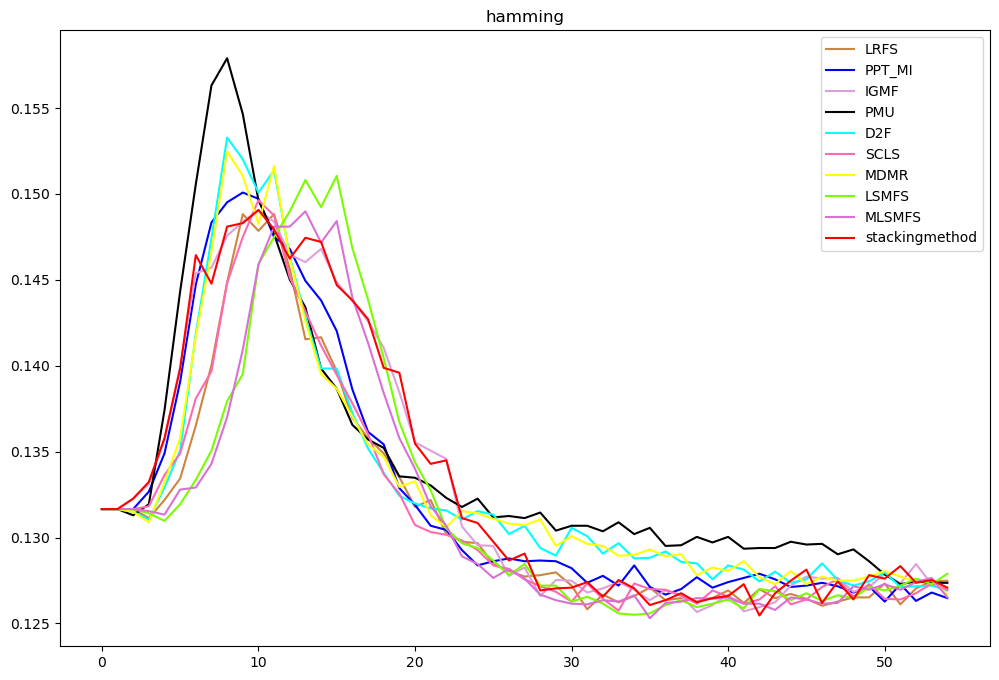

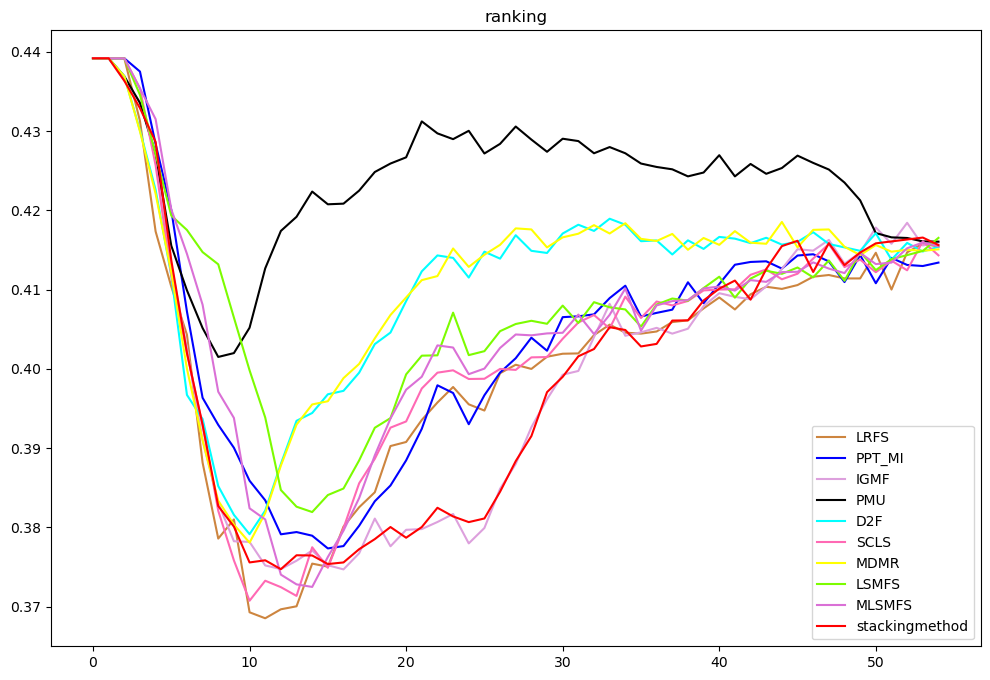

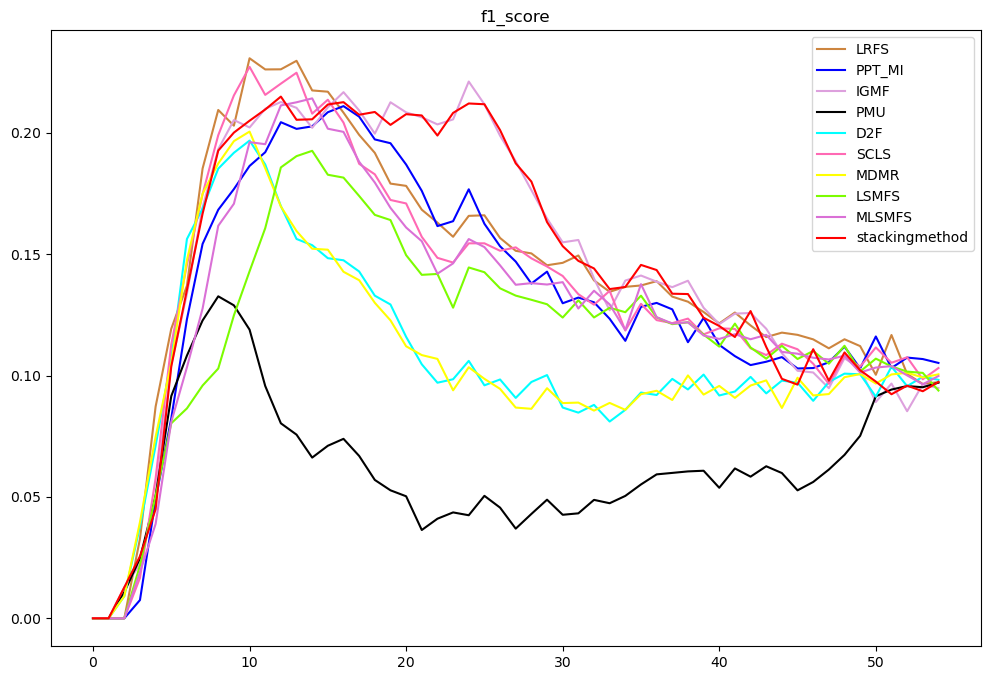

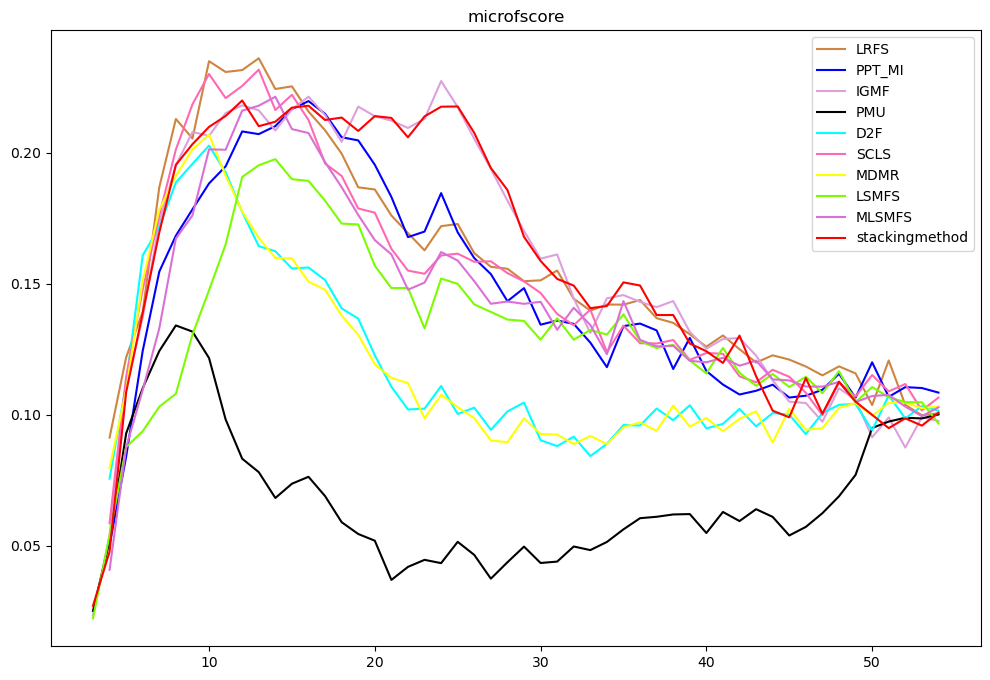

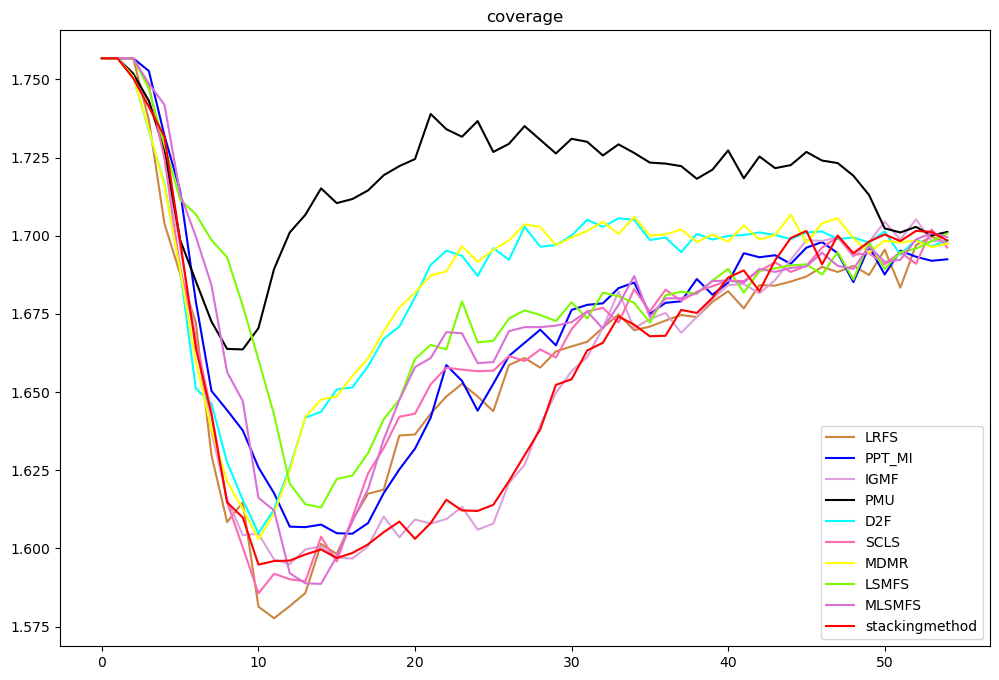

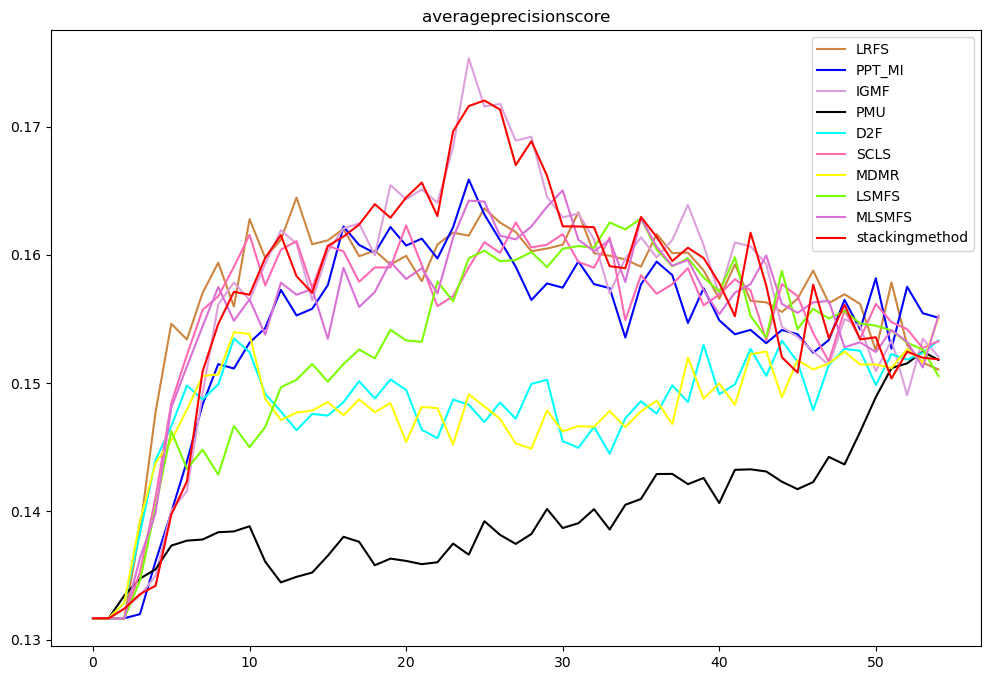

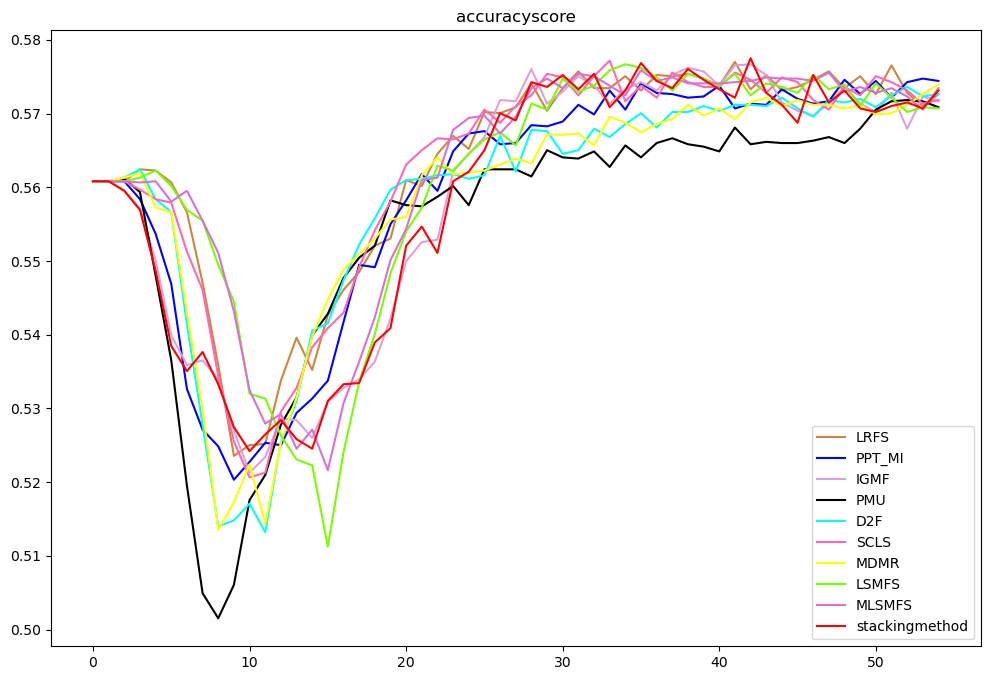

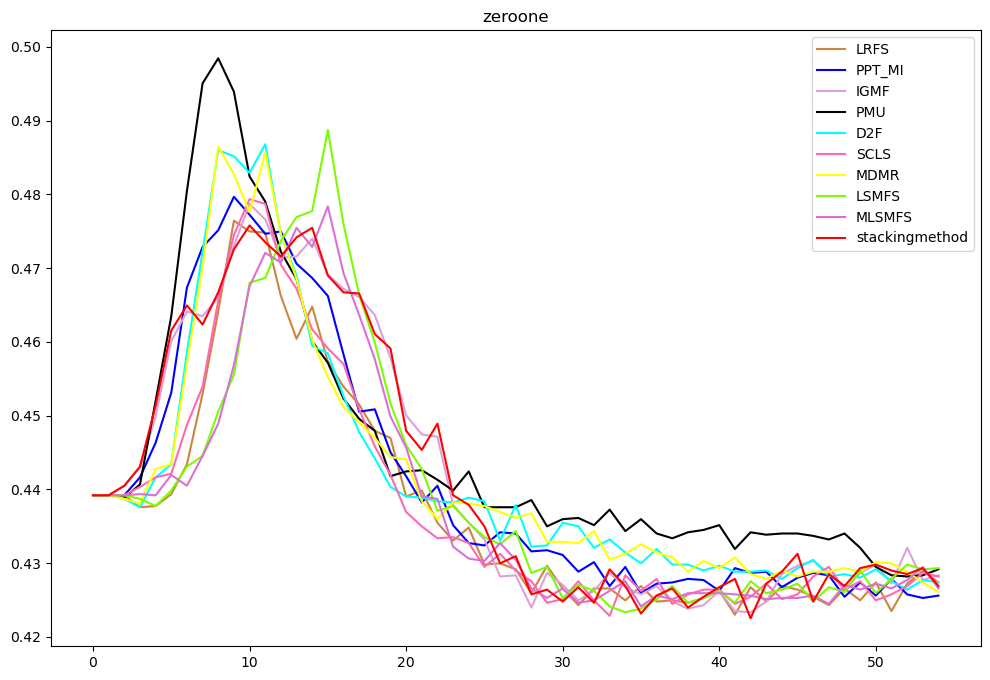

In [21]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

# Initialize allResult array
defaultmethods = ['LRFS', 'PPT_MI', 'IGMF', 'PMU', 'D2F', 'SCLS', 'MDMR', 'LSMFS', 'MLSMFS', 'stackingmethod']
metrics = ['hamming', 'ranking', 'f1_score', 'microfscore', 'coverage', 'averageprecisionscore', 'accuracyscore', 'zeroone']
foldNum = 5  # Assuming you have 5 folds; replace with your actual number of folds
allResult = np.zeros((len(metrics), len(defaultmethods), foldNum, 55))

# Fill the allResult array
for fold in range(foldNum):
    for d in args.datasets:
        for methodid, method in enumerate(defaultmethods):
            for c in args.classifiers:
                for mid, metric in enumerate(metrics):
                    dir_name = os.path.join(args.output_path, "Accuracies", d, c, metric, str(fold))
                    os.makedirs(dir_name, exist_ok=True)  # This replaces all your if not os.path.isdir(dir_name) checks
                    filename = os.path.join(dir_name, method + '.csv')
                    if os.path.exists(filename):
                        data = pd.read_csv(filename, header=None).iloc[:, 0].values
                        # Check if the data length is less than 55 and pad if necessary
                        if len(data) < 55:
                            padded_data = np.pad(data, (0, 55 - len(data)), 'constant', constant_values=np.nan)
                        else:
                            padded_data = data
                        allResult[mid, methodid, fold, :] = padded_data

# Calculate the average across all folds
average = np.mean(allResult, axis=2)  # Compute the average across the fold dimension

# Plotting
allcolors = ['peru', 'blue', 'plum', 'black', 'cyan', 'hotpink', 'yellow', 'lawngreen', 'orchid', 'red']
for mid, metric in enumerate(metrics):
    plt.figure(figsize=(12, 8))
    for methodid, method in enumerate(defaultmethods):
        plt.plot(range(55), average[mid, methodid, :], allcolors[methodid], label=method)
    plt.legend(loc='best')
    plt.title(metric)
    plt.show()


In [22]:
choiceStacking = {}
for mid in range(0,len(metrics)):   
    method = metrics[mid]
    choiceStacking[method] = []
    
for mid in range(0,len(metrics)):   
    method = metrics[mid]
    if numberindex[mid]>0:
        ave = np.max(average[mid,:,:],0)
    else:   
        ave = np.min(average[mid,:,:],0)
    for i in range(55):
        if np.isnan(np.round(ave[i],8)):
            print("存在异常值 忽略")
        else:    
            a = np.where(np.round(average[mid,:,i],8)==np.round(ave[i],8)) #当前数量特征下哪种方法最好
            indexbest = np.array(a)[0][0]
            if defaultmethods[indexbest] == "stackingmethod":
                choiceStacking[method].append(i+1)                   

存在异常值 忽略
存在异常值 忽略
存在异常值 忽略
存在异常值 忽略


In [23]:
choiceStacking ## 最终选择的结果，在某个指标下，stackingmethod方法最好的时候对应的特征数量

{'hamming': [43, 49],
 'ranking': [19, 21, 24, 27, 29, 31, 33, 36, 37, 43],
 'f1_score': [19, 22, 24, 26, 27, 29, 33, 34, 36, 37, 43],
 'microfscore': [19, 21, 22, 24, 26, 27, 28, 29, 33, 34, 36, 37, 43],
 'coverage': [19, 21, 24, 29, 31, 33, 36, 37],
 'averageprecisionscore': [19, 21, 22, 24, 26, 30, 33, 36, 41, 43],
 'accuracyscore': [31, 33, 36, 43],
 'zeroone': [31, 33, 36, 43]}

下面选择特征数量下面对应的特征id形成数据集

In [13]:
def findsetnumberStackingRank(number,foldnum = foldNum):
    countFeature={}
    for fold in range(0,foldNum):
        Subset = FoldallStackingRank[fold][number-1]
        count = 0
        while(count<number):
            feature = Subset[count]
            if feature in countFeature.keys():
                countFeature[feature] = 1+countFeature[feature]
            else:   
                countFeature[feature] = 1
            count = count+1
    sortresult1 = sorted(countFeature.items(),key=lambda x:x[1],reverse=True)
    print('feaure Num:{} '.format(number))
    print(sortresult1)
    sortresult = sortresult1[:(number-1)]
    choicesubset = [x[0] for x in sortresult]
    return choicesubset

In [14]:
#下面以21个数量为例计算 21个二特征情况下最优的特征和生成的数据集
feaure21 = findsetnumberStackingRank(33)
print(feaure21)
readData = pd.read_csv("./datasets/newdatas/data.csv")

Y = readData.iloc[:,0:4]
X = readData.iloc[: , 4:]
bestsubdataX = X.iloc[:,feaure21]

feaure Num:33 
[(54, 10), (13, 10), (24, 10), (23, 10), (22, 10), (21, 10), (20, 10), (19, 10), (18, 10), (17, 10), (16, 10), (15, 10), (14, 10), (12, 10), (26, 10), (11, 10), (10, 10), (9, 10), (8, 10), (7, 10), (6, 10), (5, 10), (4, 10), (3, 10), (2, 10), (1, 10), (25, 10), (27, 10), (53, 10), (41, 10), (52, 10), (51, 10), (50, 10)]
[54, 13, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 12, 26, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 25, 27, 53, 41, 52, 51]


In [15]:
bestsubdataX.head(10)

,GLU,DRUGa,HGB,RDW,RBC,WBC,age,DRUGg,DRUGf,DRUGe,...,ARRHYTHM,DRINKING,SMOKING,FH,PLT,N,PH,K1,LDH,CKMB
0,4.750,0,148.0,13.60,4.740,7.140,65.00,1,1,1,...,0,0,0,1,227.0,58.2,6.00,3.40,177.0,4.30
1,5.040,0,76.5,15.65,2.515,3.220,76.00,0,0,0,...,0,0,0,0,53.0,43.8,7.00,3.93,170.0,2.40
2,10.202,0,93.0,15.65,2.670,12.681,73.00,0,1,0,...,0,0,0,0,118.0,93.5,6.11,4.85,328.5,16.80
3,7.940,0,145.0,11.90,4.160,5.690,69.22,0,0,0,...,0,0,0,0,167.0,45.8,5.00,4.44,154.0,11.20
4,5.880,0,128.0,11.60,3.910,6.760,70.29,0,0,0,...,0,0,0,0,175.0,57.8,6.00,3.45,183.0,5.60
5,7.230,0,138.0,13.20,4.270,7.010,73.00,0,0,1,...,0,0,0,0,121.0,63.4,6.00,4.79,235.0,13.20
6,6.010,0,136.0,12.10,4.280,6.450,76.00,0,0,0,...,0,0,0,0,234.0,60.6,5.00,4.00,186.0,2.35
7,9.680,0,120.0,13.50,4.190,10.950,91.00,0,0,0,...,0,0,0,0,208.0,90.3,6.00,3.99,328.5,9.20
8,6.080,1,124.0,12.00,4.090,5.830,69.85,0,0,0,...,0,0,0,0,284.0,64.3,6.50,3.93,188.0,1.24
9,4.350,0,76.5,15.65,3.070,9.140,75.00,0,0,0,...,0,0,0,0,374.5,86.9,6.50,4.37,160.4,12.80


In [16]:
# 提取最优子集数据
# 将筛选的特征与标签合并
new_data = pd.concat([Y, bestsubdataX], axis=1)

# 将合并后的数据保存为新的 CSV 文件
new_data.to_csv("CHD-BR-RF33feature.csv", index=False)

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

output_folder = "01_CHD_00_BRRF"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

allcolors = ['peru','blue','plum','black','cyan','hotpink','yellow','lawngreen','orchid','red']
for mid in range(len(metrics)):
    m = metrics[mid]

    # 计算平均值
    avg_data = pd.DataFrame(average[mid,:,:].T, columns=defaultmethods, index=range(1, 56))

    # 为每个特征计算标准差
    std_data = []
    for feature_index in range(allResult.shape[3]):
        feature_std = np.std(allResult[mid,:, :, feature_index], axis=1)
        std_data.append(feature_std)
    std_data = pd.DataFrame(std_data, columns=defaultmethods, index=range(1, 56))

    # 保存平均值和标准差数据到CSV
    csv_filename_avg = os.path.join(output_folder, f'{m}_average_results.csv')
    avg_data.to_csv(csv_filename_avg)
    csv_filename_std = os.path.join(output_folder, f'{m}_std_results.csv')
    std_data.to_csv(csv_filename_std)

    # 绘制图形
    count = 0
    plt.figure(figsize=(12,8))
    for methodid in range(len(defaultmethods)):
        method = defaultmethods[methodid]
        plt.plot(range(1, allResult.shape[3]+1), average[mid, methodid, :], allcolors[count], label=method)
        count += 1
    plt.legend(loc='best')
    plt.title(m)

    # 保存图形为PNG，分辨率为300 DPI
    png_filename = os.path.join(output_folder, f'{m}_plot.png')
    plt.savefig(png_filename, dpi=300)
    
    # 同时保存图形为SVG格式
    svg_filename = os.path.join(output_folder, f'{m}_plot.svg')
    plt.savefig(svg_filename, dpi=300)
    
    plt.close()  # 关闭图形，避免在内存中累积
